In [4]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import xesmf as xe
import gcsfs
import cartopy.crs as ccrs
import cartopy
import regionmask
from pyproj import Proj, Transformer, CRS
import geopandas
import rioxarray
from shapely.geometry import mapping
import seaborn as sns

%matplotlib inline

def fix_calendar(ds, timevar='T'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

def fix_coords(ds):
    ds = ds.assign_coords(X=(((ds.X + 180) % 360) - 180)).sortby(['X','Y']).rename({'X':'lon','Y':'lat'})
    return ds

period= slice('2017-12-16','2018-11-16')
period1 = slice('2016-12-16','2017-11-16')
period_burn = slice('2018-06-15','2018-11-15')
seasons = ['DJF','MAM','JJA','SON']

In [13]:
precip.tp

<xarray.DataArray 'tp' (T: 488, lat: 181, lon: 360)>
array([[[0.08388508, 0.08388508, 0.08388508, ..., 0.08388508,
         0.08388508, 0.08388508],
        [0.07102678, 0.07133294, 0.07255754, ..., 0.07010833,
         0.07010833, 0.07102678],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.29237318, 0.28992397, 0.28716865, ..., 0.3064561 ,
         0.30186382, 0.29696542],
        [0.29084244, 0.28900552, 0.28716865, ..., 0.29727158,
         0.29451624, 0.29267934],
        [0.2721673 , 0.2721673 , 0.2721673 , ..., 0.2721673 ,
         0.2721673 , 0.2721673 ]],

       [[0.03490109, 0.03490109, 0.03490109, ..., 0.03490109,
         0.03490109, 0.03490109],
        [0.03888104, 0.06582224, 0.06643453, ..., 0.06490379,
         0.06490379, 0.06520993],
        [0.09062038, 0.09184498, 0.09306958, ..., 0.08694658,
         0.08817117, 0.08939578],
...
        [0.70696485, 0.7134518 , 0.71561414, ..., 0.6965857 ,
         0.6991805 , 0.7022078 ],
        [0.5538729 , 0.5543054 , 0.5543054 , ..., 0.55344045,
         0.55344045, 0.5538729 ],
        [0.5114915 , 0.5114915 , 0.5114915 , ..., 0.5114915 ,
         0.5114915 , 0.5114915 ]],

       [[0.14130297, 0.14130297, 0.14130297, ..., 0.14130297,
         0.14130297, 0.14130297],
        [0.20011799, 0.20184785, 0.20357768, ..., 0.19579335,
         0.19709074, 0.19882058],
        [0.18714409, 0.1940635 , 0.20055044, ..., 0.17244034,
         0.17719743, 0.182387  ],
        ...,
        [1.0217981 , 1.0166086 , 1.0148787 , ..., 1.0386642 ,
         1.033907  , 1.0287175 ],
        [0.98028165, 0.98028165, 0.98071414, ..., 0.9789841 ,
         0.9794166 , 0.97984916],
        [1.033907  , 1.033907  , 1.033907  , ..., 1.033907  ,
         1.033907  , 1.033907  ]]], dtype=float32)
Coordinates:
  * T        (T) object 1979-01-16 00:00:00 ... 2019-08-16 00:00:00
  * lon      (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Attributes:
    units:    mm/day

precip, evap, soil moisture, subsidence in atm, direction of winds
monthly & seasonal 
look at anomaly relative to climatology from 1979 - 
look back to 2017 winter

to dos 11/30

-multiply soil moisture by soil depth to get m^3/m^2

-make temperature anomaly plot

-divide by std for soil moisture and temp

-look at 700mb winds (don't plot where mountains above 700mb)

-700mb vertical velocity

-make VPD

In [690]:
#!wget -O u.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.PressureLevels/.u.nc/data.cdf
#!wget -O v.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.PressureLevels/.v.nc/data.cdf
#!wget -O w.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.PressureLevels/.w.nc/data.cdf
#!wget -O z.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.PressureLevels/.z.nc/data.cdf

#!wget -O u10.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Surface/.u10.nc/data.cdf
#!wget -O v10.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Surface/.v10.nc/data.cdf
#!wget -O t2m.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Surface/.t2m.nc/data.cdf
#!wget -O d2m.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Surface/.d2m.nc/data.cdf
#!wget -O sst.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Surface/.sst.nc/data.cdf
#!wget -O sp.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Surface/.sp.nc/data.cdf


--2020-12-06 17:38:08--  http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.PressureLevels/.z.nc/data.cdf
Resolving kage.ldeo.columbia.edu... 129.236.21.133
Connecting to kage.ldeo.columbia.edu|129.236.21.133|:81... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2035082460 (1.9G) [application/x-netcdf]
Saving to: ‘z.cdf’

z.cdf               100%[===================>]   1.89G  36.7MB/s    in 50s     

2020-12-06 17:39:04 (38.9 MB/s) - ‘z.cdf’ saved [2035082460/2035082460]

--2020-12-06 17:39:06--  http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Surface/.sp.nc/data.cdf
Resolving kage.ldeo.columbia.edu... 129.236.21.133
Connecting to kage.ldeo.columbia.edu|129.236.21.133|:81... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127197180 (121M) [application/x-netcdf]
Saving to: ‘sp.cdf’

sp.cdf              100%[===================>] 121.30M  39.0MB/s    in 3.1s    

2020-12-06 17:39:09 (39.0 MB/s) - ‘sp.cdf’ save

In [285]:
ds = xr.merge([precip,u700.rename({'u':'u700'}),v700.rename({'v':'v700'}),w700.rename({'w':'w700'}),sst,z200.drop('P'),d2m,T])
#ds.to_netcdf('ERA-I_v0.nc')

In [365]:
forest = xr.open_dataset('forest.nc')
#forest = xr.decode_cf(forest, decode_times = True)
forest = forest.sel(year = slice(1984,2018))
forest

<xarray.Dataset>
Dimensions:  (X: 155, Y: 208, year: 35)
Coordinates:
  * X        (X) float64 -2.353e+06 -2.341e+06 ... -5.172e+05 -5.052e+05
  * Y        (Y) float64 3.172e+06 3.16e+06 3.148e+06 ... 6.995e+05 6.875e+05
  * year     (year) float64 1.984e+03 1.985e+03 ... 2.017e+03 2.018e+03
Data variables:
    forest   (year, Y, X) float32 ...

In [366]:
burn

<xarray.Dataset>
Dimensions:      (X: 155, Y: 208, time: 420)
Coordinates:
  * X            (X) float64 -2.353e+06 -2.341e+06 ... -5.172e+05 -5.052e+05
  * Y            (Y) float64 3.172e+06 3.16e+06 ... 6.995e+05 6.875e+05
  * time         (time) datetime64[ns] 1984-01-15 1984-02-15 ... 2018-12-15
    spatial_ref  int64 0
Data variables:
    burnarea     (time, Y, X) float32 ...
Attributes:
    grid_mapping:  spatial_ref

In [342]:
dt_years = np.array([np.datetime64(str(int(year))) for year in forest.year.values])
dt_years

array(['1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018'], dtype='datetime64[Y]')

In [352]:
forest

<xarray.Dataset>
Dimensions:  (X: 155, Y: 208, time: 35, year: 35)
Coordinates:
  * X        (X) float64 -2.353e+06 -2.341e+06 ... -5.172e+05 -5.052e+05
  * Y        (Y) float64 3.172e+06 3.16e+06 3.148e+06 ... 6.995e+05 6.875e+05
  * year     (year) datetime64[ns] 1899-02-09T21:44:17.796874240 ... 1786-04-...
  * time     (time) datetime64[ns] 2142-12-23T05:09:20.089784320 ... 2109-08-...
Data variables:
    forest   (year, Y, X) float32 ...

In [320]:
forest.rename({'year':'time'}).resample(time="1M").interpolate("linear")

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Float64Index'

In [5]:
# total precip (go from m/s to mm/day)e 
precip = xr.open_dataset('tp.cdf',decode_times=False)
precip = 8.64e+7*xr.decode_cf(fix_calendar(precip))
precip.tp.attrs['units'] = 'mm/day'
# fix lon coordinates
precip = fix_coords(precip)

# evap ? (go from m/s to mm/day, make evaporation positive)
evap = xr.open_dataset('evap.cdf',decode_times=False)
evap = -1*8.64e+7*xr.decode_cf(fix_calendar(evap))
evap.evap.attrs['units'] = 'mm/day'
# fix lon coordinates
evap = fix_coords(evap)

# soil moistures
sm1 = xr.open_dataset('swvl1.cdf', decode_times=False)
sm1 = fix_coords(xr.decode_cf(fix_calendar(sm1)))

sm2 = xr.open_dataset('swvl2.cdf', decode_times=False)
sm2 = fix_coords(xr.decode_cf(fix_calendar(sm2)))

sm3 = xr.open_dataset('swvl3.cdf', decode_times=False)
sm3 = fix_coords(xr.decode_cf(fix_calendar(sm3)))

sm4 = xr.open_dataset('swvl4.cdf', decode_times=False)
sm4 = fix_coords(xr.decode_cf(fix_calendar(sm4)))

# winds
u = xr.open_dataset('u10.cdf',decode_times=False)
u = fix_coords(xr.decode_cf(fix_calendar(u)))

v = xr.open_dataset('v10.cdf',decode_times=False)
v = fix_coords(xr.decode_cf(fix_calendar(v)))

w = xr.open_dataset('w.cdf',decode_times=False)
w = fix_coords(xr.decode_cf(fix_calendar(w)))

u700 = xr.open_dataset('u.cdf',decode_times=False).sel(P=700)
u700 = fix_coords(xr.decode_cf(fix_calendar(u700)))

v700 = xr.open_dataset('v.cdf',decode_times=False).sel(P=700)
v700 = fix_coords(xr.decode_cf(fix_calendar(v700)))

w700 = xr.open_dataset('w.cdf',decode_times=False).sel(P=700)
w700 = fix_coords(xr.decode_cf(fix_calendar(w700)))

# sst

sst = xr.open_dataset('sst.cdf',decode_times=False)
sst = fix_coords(xr.decode_cf(fix_calendar(sst)))

In [51]:
# burn area
burn = xr.open_dataset('burnarea_mtbs_only.nc',decode_times=False)
burn = xr.decode_cf(burn, decode_times = True)
burn = burn.sel(time = slice('1984-01-15','2018-12-15'))

# set up burn with rioxarray 
burn.rio.set_spatial_dims(x_dim="X", y_dim="Y", inplace=True)
burn.rio.write_crs("epsg:5070", inplace=True)

# read california shape file
cali = geopandas.read_file('CA_State_TIGER2016.shp')

# mask burn with california shapefile
burn_cali = burn.rio.clip(cali.geometry.apply(mapping), cali.crs, drop=False)
burn_cali = burn_cali.sum(['X','Y'])

In [256]:
# height
g = 9.80665
z200 = xr.open_dataset('z.cdf',decode_times=False).sel(P=200)/g
z200 = fix_coords(xr.decode_cf(fix_calendar(z200))).rename({'z':'z200'})

# surface pressure (go from Pa to mb)
sp = xr.open_dataset('z.cdf',decode_times=False)/100.
sp = fix_coords(xr.decode_cf(fix_calendar(sp)))

In [254]:
# 2m temp

T = xr.open_dataset('t2m.cdf',decode_times=False)
T = fix_coords(xr.decode_cf(fix_calendar(T)))
# 2m dew point temp 

d2m = xr.open_dataset('d2m.cdf',decode_times=False)
d2m = fix_coords(xr.decode_cf(fix_calendar(d2m)))

In [6]:
# VPD 

es0 = 6.11 #mb
c1 = 17.67 
T0 =  273.15 #K
es_a = es0*np.exp(c1*(T - T0)/(T - T0 + 243.5))
ea = es0*np.exp(c1*(d2m - T0)/(d2m - T0 + 243.5))
VPD = es_a - ea
VPD = VPD.rename({'temp':'VPD'})
VPD.VPD.attrs['units'] = 'mbar'


In [6]:
# calculate 1979-2019 climatologies
p_clim_m = precip.groupby('T.month').mean()
p_clim_s = precip.groupby('T.season').mean()

e_clim_m = evap.groupby('T.month').mean()
e_clim_s = evap.groupby('T.season').mean()

sm_ms = [_ for x in range(4)]
sm_ss = [_ for x in range(4)]
sm_stds_s = [_ for x in range(4)]

for i, sm in enumerate([sm1, sm2, sm3, sm4]):
    sm_ms[i] = sm.groupby('T.month').mean()
    sm_ss[i] = sm.groupby('T.season').mean()
    sm_stds_s[i] = sm.groupby('T.season').std()
    
u_clim_m = u.groupby('T.month').mean()
u_clim_s = u.groupby('T.season').mean()

v_clim_m = v.groupby('T.month').mean()
v_clim_s = v.groupby('T.season').mean()

w_clim_m = w.groupby('T.month').mean()
w_clim_s = w.groupby('T.season').mean()

z200_clim_m = z200.groupby('T.month').mean()
z200_clim_s = z200.groupby('T.season').mean()

u700_clim_m = u700.groupby('T.month').mean()
u700_clim_s = u700.groupby('T.season').mean()

v700_clim_m = v700.groupby('T.month').mean()
v700_clim_s = v700.groupby('T.season').mean()

w700_clim_m = w700.groupby('T.month').mean()
w700_clim_s = w700.groupby('T.season').mean()

T_clim_m = T.groupby('T.month').mean()
T_clim_s = T.groupby('T.season').mean()

T_std_s = T.groupby('T.season').std()

d2m_clim_m = d2m.groupby('T.month').mean()
d2m_clim_s = d2m.groupby('T.season').mean()

VPD_clim_m = VPD.groupby('T.month').mean()
VPD_clim_s = VPD.groupby('T.season').mean()
VPD_std_s = VPD.groupby('T.season').std()

sst_clim_m = sst.groupby('T.month').mean()
sst_clim_s = sst.groupby('T.season').mean()
sst_std_s = sst.groupby('T.season').std()

sp_clim_m = sp.groupby('T.month').mean()
sp_clim_s = sp.groupby('T.season').mean()

NameError: name 'z200' is not defined

In [ ]:
# calculate anomalies from 1979-2018 mean
p_anom_m = precip.groupby('T.month') - p_clim_m
p_anom_s = precip.groupby('T.season') - p_clim_s

e_anom_m = evap.groupby('T.month') - e_clim_m
e_anom_s = evap.groupby('T.season') - e_clim_s

sm_anoms_m = [_ for x in range(4)]
sm_anoms_s = [_ for x in range(4)]

for i, sm in enumerate([sm1, sm2, sm3, sm4]):
    sm_anoms_m[i] = sm.groupby('T.month') - sm_ms[i]
    sm_anoms_s[i] = sm.groupby('T.season') - sm_ss[i]
    
u_anom_m = u.groupby('T.month') - u_clim_m
u_anom_s = u.groupby('T.season') - u_clim_s

v_anom_m = v.groupby('T.month') - v_clim_m
v_anom_s = v.groupby('T.season') - v_clim_s

w_anom_m = w.groupby('T.month') - w_clim_m
w_anom_s = w.groupby('T.season') - w_clim_s

u700_anom_m = u700.groupby('T.month') - u700_clim_m
u700_anom_s = u700.groupby('T.season') - u700_clim_s

v700_anom_m = v700.groupby('T.month') - v700_clim_m
v700_anom_s = v700.groupby('T.season') - v700_clim_s

w700_anom_m = w700.groupby('T.month') - w700_clim_m
w700_anom_s = w700.groupby('T.season') - w700_clim_s

T_anom_m = T.groupby('T.month') - T_clim_m
T_anom_s = T.groupby('T.season') - T_clim_s

d2m_anom_m = d2m.groupby('T.month') - d2m_clim_m
d2m_anom_s = d2m.groupby('T.season') - d2m_clim_s

VPD_anom_m = VPD.groupby('T.month') - VPD_clim_m
VPD_anom_s = VPD.groupby('T.season') - VPD_clim_s

sst_anom_m = sst.groupby('T.month') - sst_clim_m
sst_anom_s = sst.groupby('T.season') - sst_clim_s

z200_anom_m = z200.groupby('T.month') - z200_clim_m
z200_anom_s = z200.groupby('T.season') - z200_clim_s

sp_anom_m = sp.groupby('T.month') - sp_clim_m
sp_anom_s = sp.groupby('T.season') - sp_clim_s

## Burned area

In [370]:
burn.time.

<xarray.DataArray 'time' (time: 420)>
array(['1984-01-15T00:00:00.000000000', '1984-02-15T00:00:00.000000000',
       '1984-03-15T00:00:00.000000000', ..., '2018-10-15T00:00:00.000000000',
       '2018-11-15T00:00:00.000000000', '2018-12-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 1984-01-15 1984-02-15 ... 2018-12-15
    spatial_ref  int64 0
Attributes:
    long_name:  time

In [368]:
burn.assign_coords({'year': burn.time.year})

AttributeError: 'DataArray' object has no attribute 'year'

Text(0.5, 0.98, 'MTBS burned area 2018')

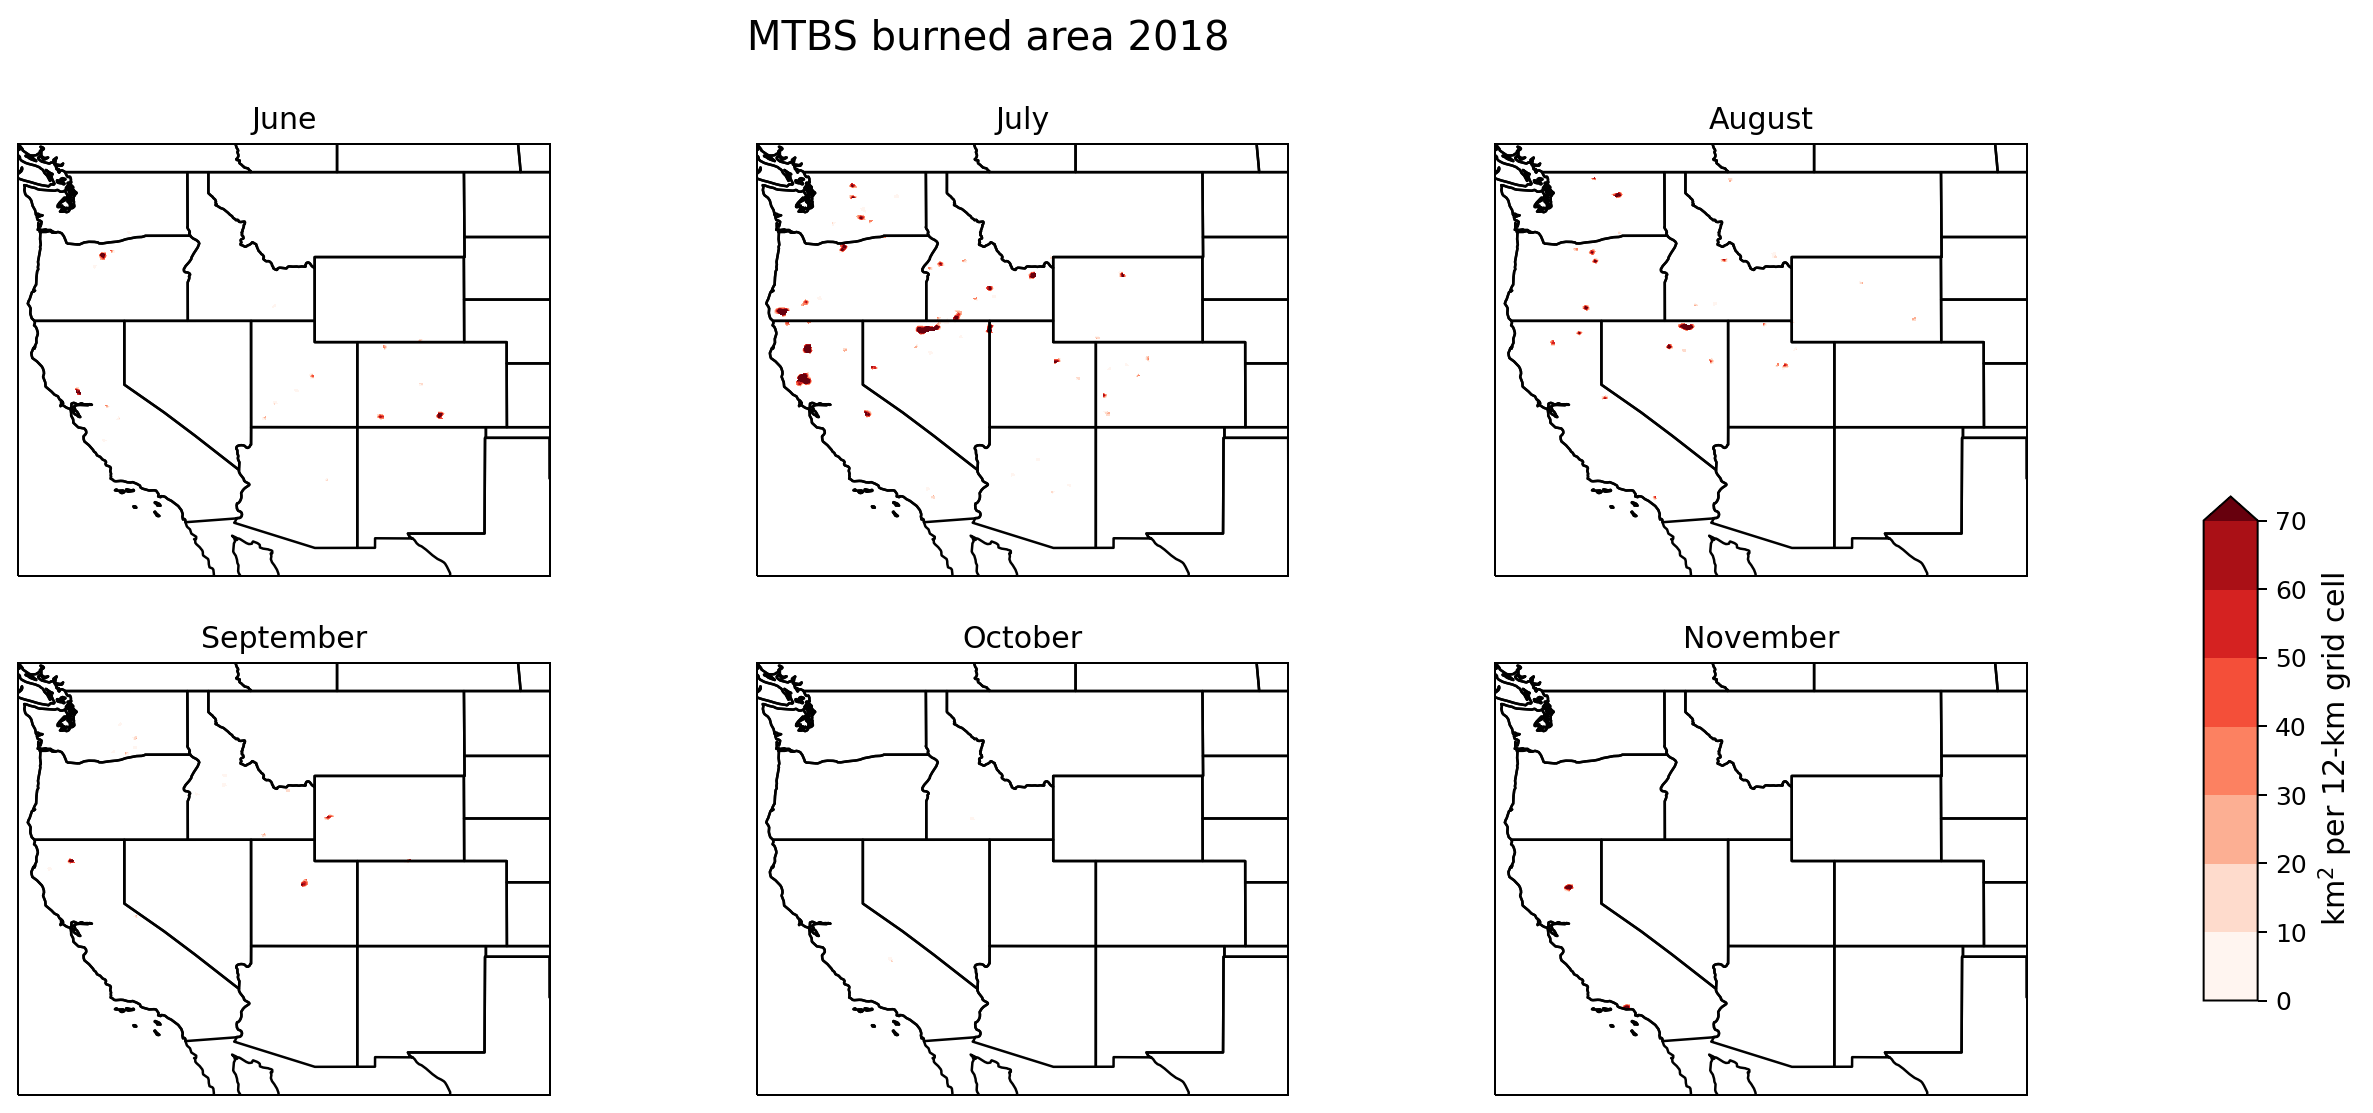

In [498]:
fig, ax = plt.subplots(2,3,figsize=(15,7),dpi=180)
extent = [-125,-100,30,50]

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,3,i+1,projection=ccrs.PlateCarree())
    im = burn.where(burn.burnarea>0).sel(time=period_burn).isel(time=i).burnarea.plot.contourf(
        ax=ax, vmax=70,levels=8, cmap='Reds',add_colorbar=False, transform = ccrs.AlbersEqualArea(
        central_longitude = -96,
        central_latitude = 23,
        false_easting = 0,
        false_northing = 0,
        standard_parallels = (29.5, 45.5)))
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    #gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
    #                      linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(burn.sel(time=period_burn).isel(time=i).time.dt.strftime('%B').values.item())
    
ax = fig.add_axes((.95,.2,.02,.4))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='km$^2$ per 12-km grid cell',size=12)
plt.suptitle('MTBS burned area 2018',fontsize=16)
#plt.tight_layout()
#plt.savefig

Text(0.5, 1.0, 'California burned area 1984-2018')

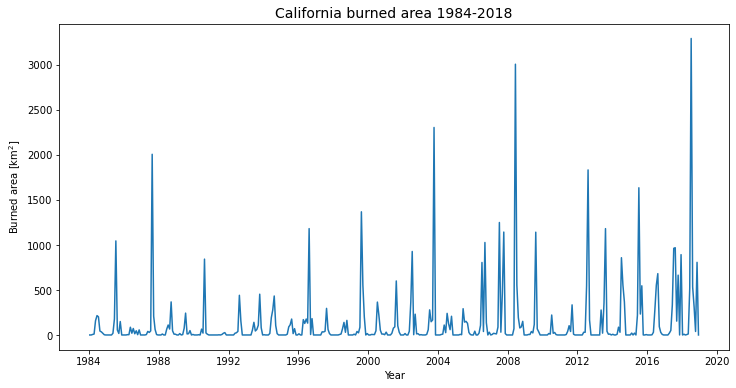

In [52]:
plt.figure(figsize=(12,6))
plt.plot(burn_cali.time,burn_cali.burnarea)
plt.xlabel('Year')
plt.ylabel('Burned area [km$^2$]')
plt.title('California burned area 1984-2018',fontsize=14)

Text(0, 0.5, 'burned area [km$^2$]')

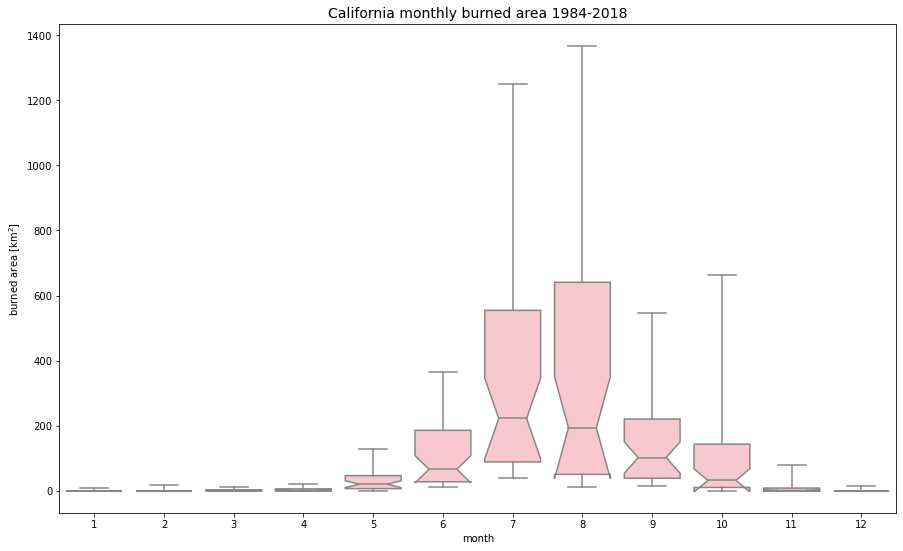

In [61]:
df = burn_cali.drop('spatial_ref').to_dataframe()
plt.figure(figsize=(15,9))
df['month'] = df.index.month
sns.boxplot(data = df, x='month', y='burnarea',color='pink', showfliers=False, notch=True, whis=(5.,95.))
plt.title('California monthly burned area 1984-2018',fontsize=14)
plt.ylabel('burned area [km$^2$]')

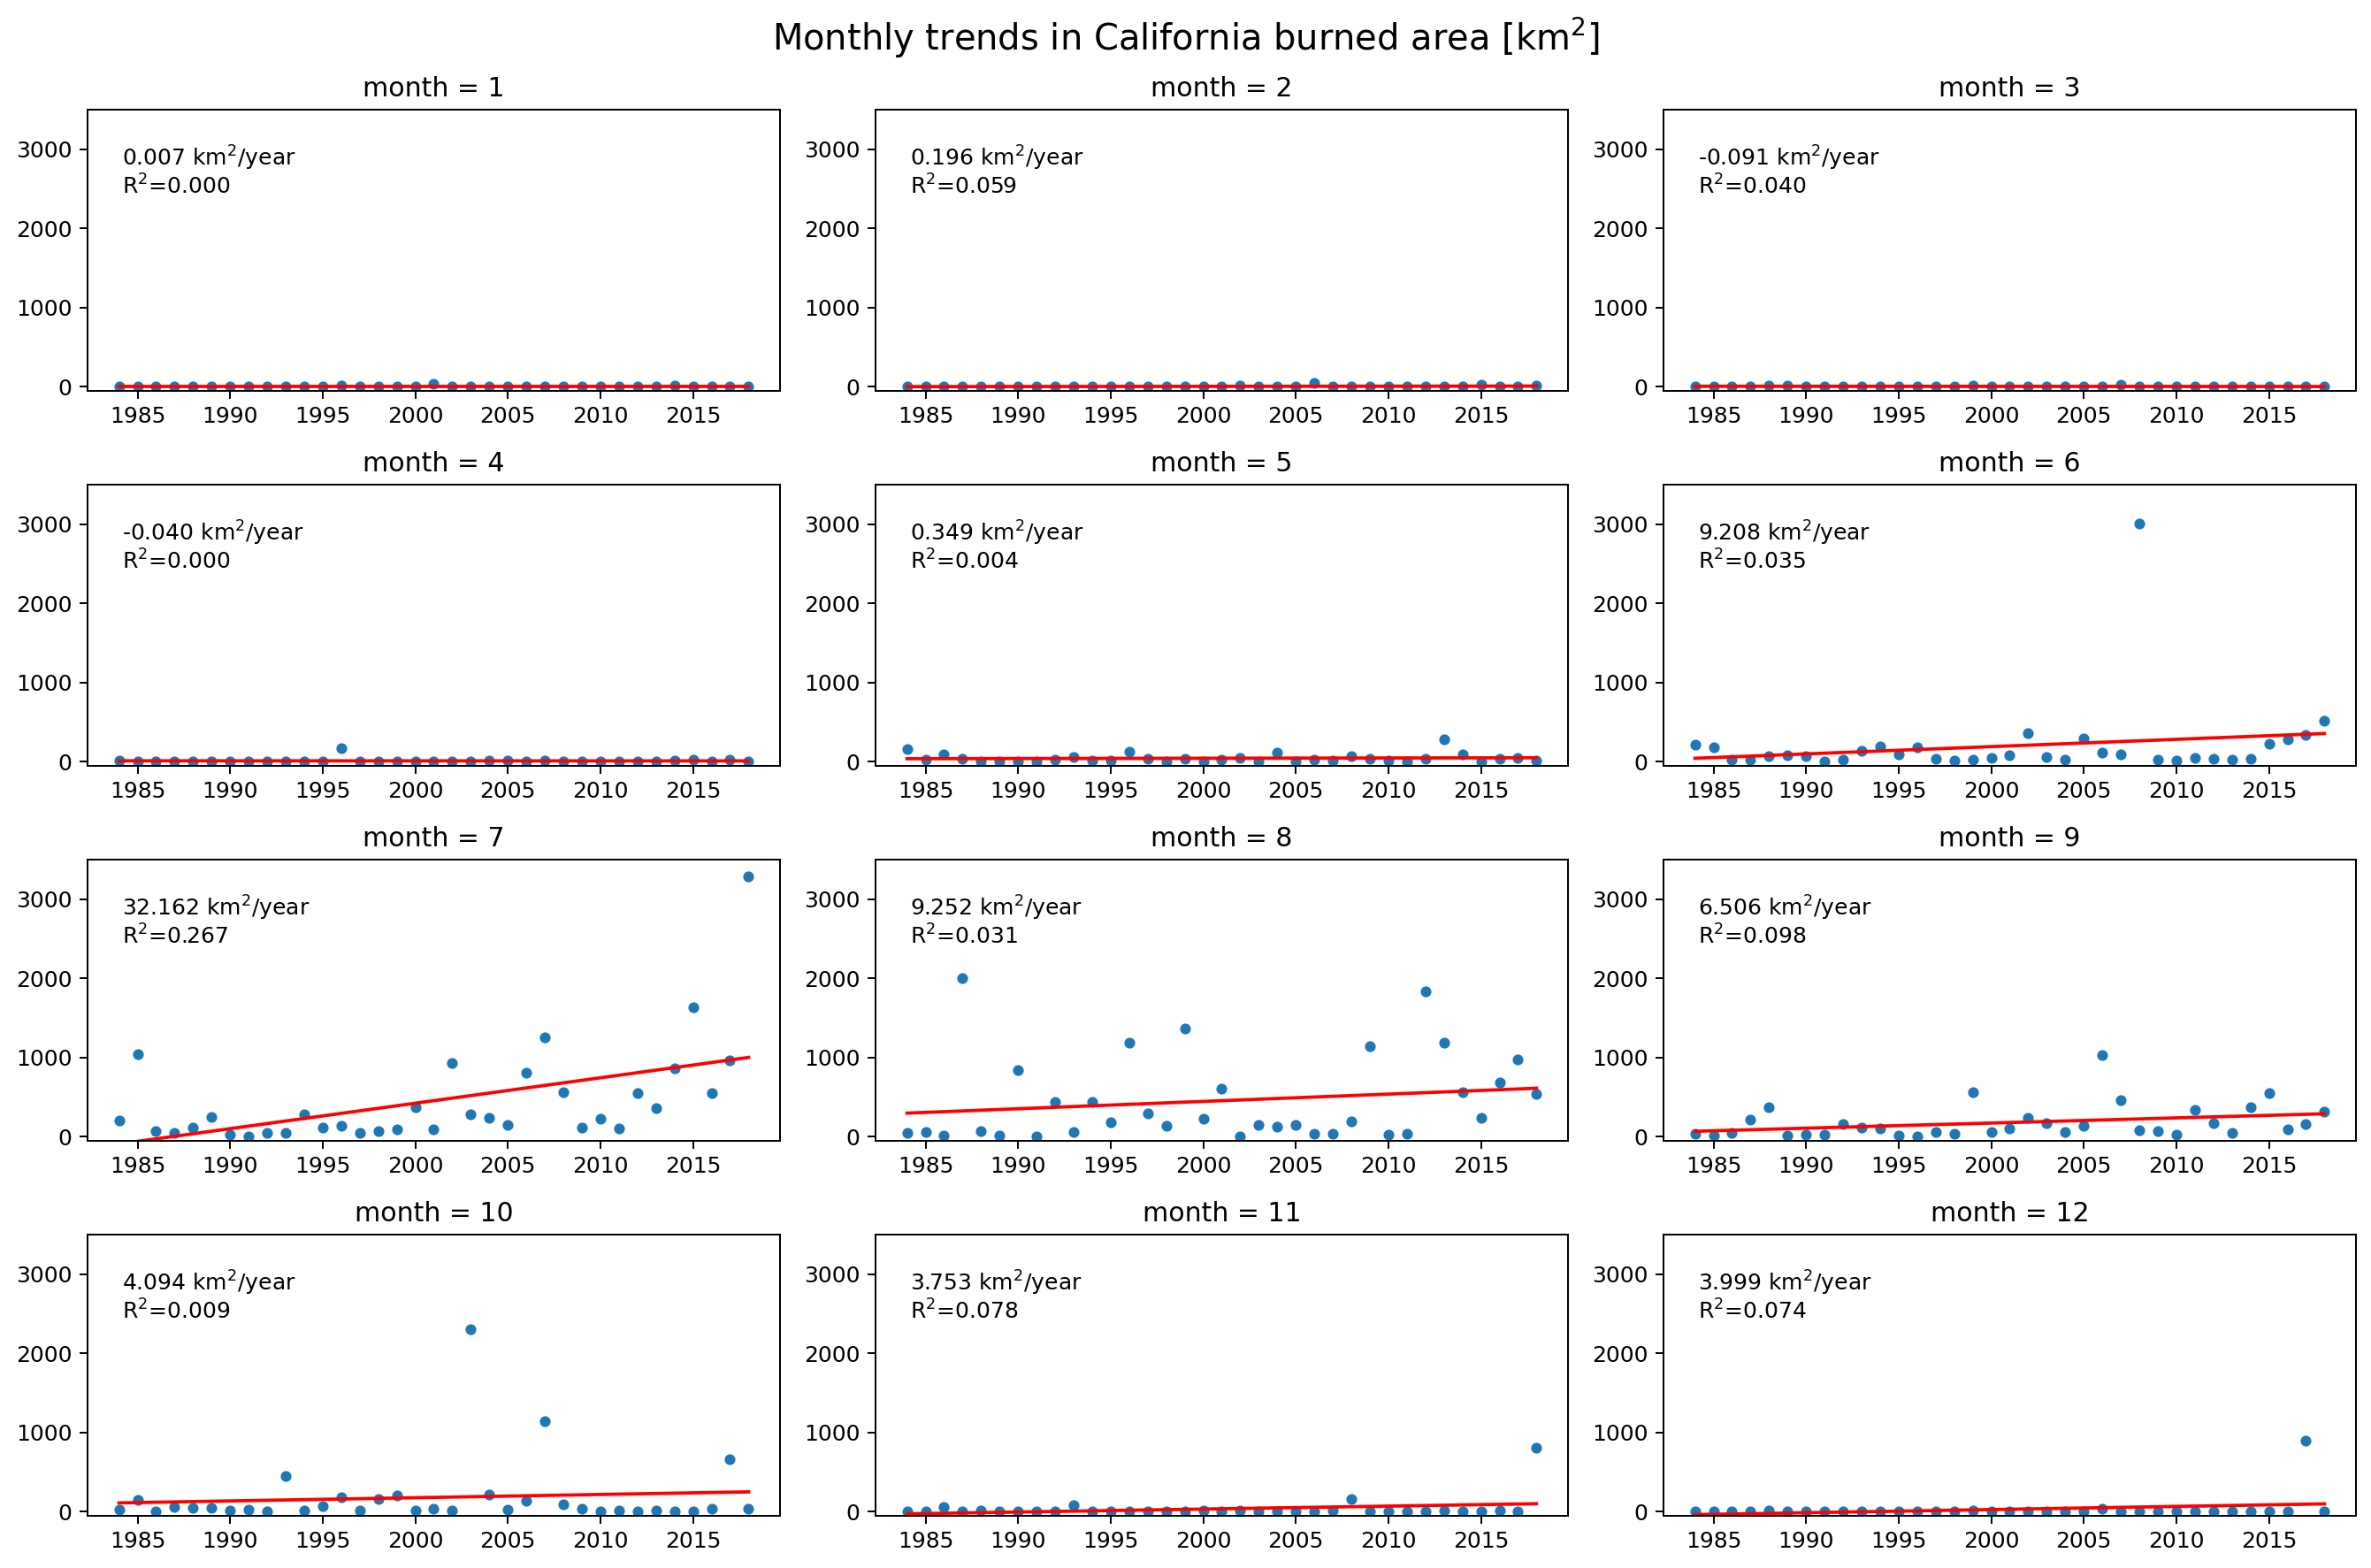

In [372]:
burn_cali_m = burn_cali.groupby('time.month')

fig, ax = plt.subplots(4,3,figsize=(15,10),dpi=180,sharex=True)
idxs = burn_cali_m.groups

for i, ax in enumerate(ax.flatten()):
    month_idxs = idxs[1+i]
    ds=burn_cali.isel(time=month_idxs).groupby('time.year').mean()
    slope = ds.polyfit(dim='year',deg=1).burnarea_polyfit_coefficients.sel(degree=1)
    intercept = ds.polyfit(dim='year',deg=1).burnarea_polyfit_coefficients.sel(degree=0)
    fit = [slope * i + intercept for i in ds.year]
    resid = ds.polyfit('year',1,full=True).burnarea_polyfit_residuals
    r2 = 1 - (resid / (ds.year.size * ds.burnarea.var('year')))
    ax = plt.subplot(4,3,i+1)
    ax.text(0.05, 0.8,s=f'%.3f km$^2$/year'%slope.item(),transform=ax.transAxes)
    ax.text(0.05, 0.7,s=f'R$^2$=%.3f'%r2.item(),transform=ax.transAxes)
    ax.plot(ds.year,fit,c='r')
    ax.scatter(ds.year, ds.burnarea,s=15)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_ylim([-50,3500])
    ax.set_title(f'month = {i+1}')
    ax.plot

plt.suptitle('Monthly trends in California burned area [km$^2$]', fontsize=16)
plt.tight_layout()


In [67]:
ds_m7=burn_cali.isel(time=idxs[7]).groupby('time.year').mean()
slope = ds_m7.polyfit(dim='year',deg=1).burnarea_polyfit_coefficients.sel(degree=1)
intercept = ds_m7.polyfit(dim='year',deg=1).burnarea_polyfit_coefficients.sel(degree=0)
fit = [slope * i + intercept for i in ds.year]
ds_m7_detrend = ds_m7 - fit
ds_m7_detrend

<xarray.Dataset>
Dimensions:      (year: 35)
Coordinates:
    spatial_ref  int64 0
  * year         (year) int64 1984 1985 1986 1987 1988 ... 2015 2016 2017 2018
Data variables:
    burnarea     (year) float64 295.8 1.107e+03 101.6 ... -4.799 2.294e+03

In [271]:
precip.

<xarray.Dataset>
Dimensions:  (T: 488, lat: 181, lon: 360)
Coordinates:
  * T        (T) object 1979-01-16 00:00:00 ... 2019-08-16 00:00:00
  * lon      (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    tp       (T, lat, lon) float32 0.08388508 0.08388508 ... 1.033907 1.033907

In [208]:

import scipy.stats as stats

def linear_trend(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return xr.DataArray(slope)

def rval(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return xr.DataArray(r_value)

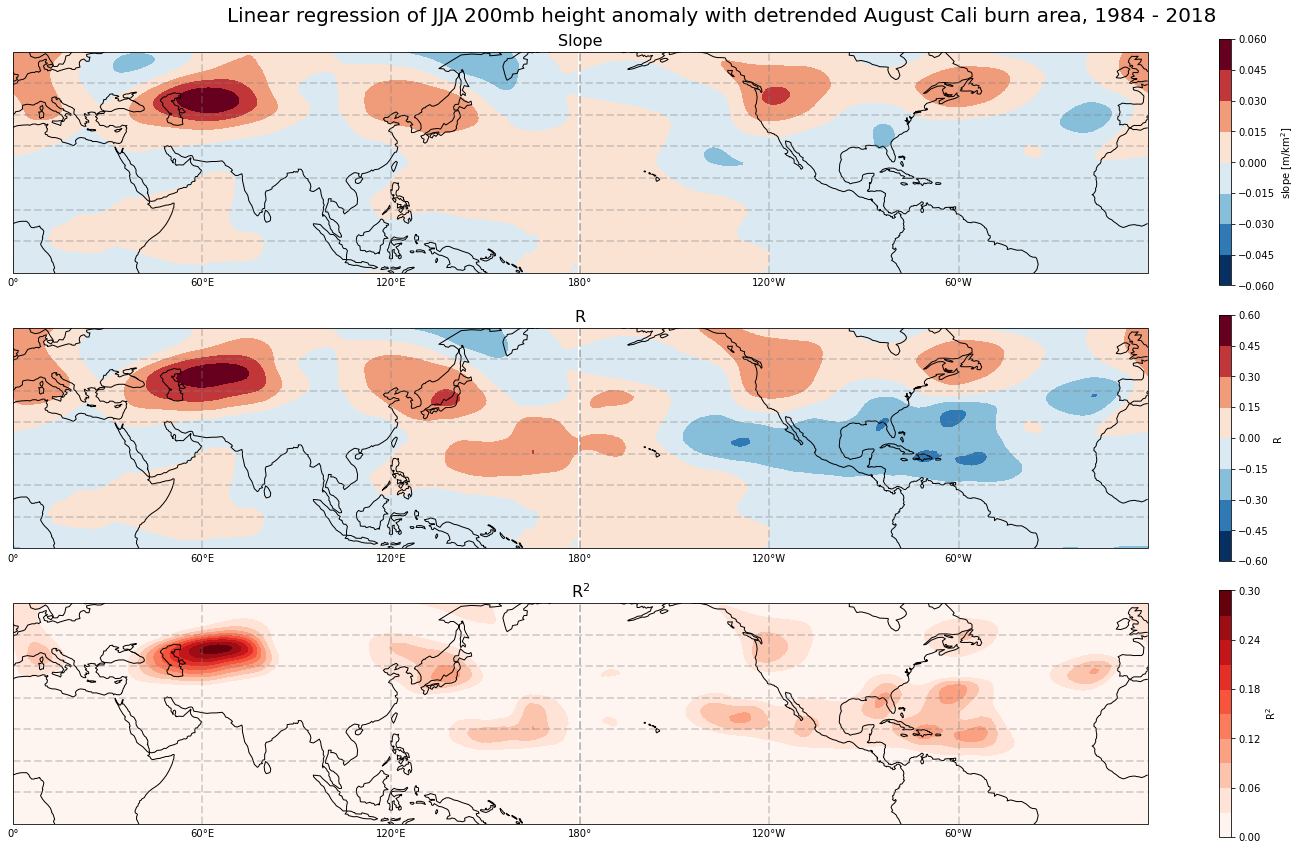

In [209]:
z200_fit = z200_anom_m.sel(T=slice('1984-01-15','2018-12-16')).isel(T=idxs[7]).groupby('T.year').mean()
z200_burn_fit = xr.merge([z200_fit,ds_m7_detrend])
slopes = xr.apply_ufunc(linear_trend,
                        z200_burn_fit.burnarea, z200_burn_fit.z,
                        vectorize=True,
                        input_core_dims=[['year'], ['year']],# reduce along 'year'
                        )

r = xr.apply_ufunc(rval,
                        z200_burn_fit.burnarea, z200_burn_fit.z,
                        vectorize=True,
                        input_core_dims=[['year'], ['year']],# reduce along 'year'
                        )

plt.subplots(3,1,figsize=(20,12))
extent = [0, 359, -10, 60]

ax = plt.subplot(3,1,1,projection=ccrs.PlateCarree(central_longitude=180))
im = slopes.plot.contourf(ax=ax, levels=11, cmap='RdBu_r',transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1, 'label':'slope [m/km$^2$]'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent(extent)    
ax.set_title('Slope',fontsize=16)

ax1 = plt.subplot(3,1,3,projection=ccrs.PlateCarree(central_longitude=180))
im = (r**2).plot.contourf(ax=ax1, levels=11, cmap='Reds',transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1, 'label':'R$^2$'})
ax1.coastlines()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_extent(extent)    
ax1.set_title('R$^2$',fontsize=16)

ax2 = plt.subplot(3,1,2,projection=ccrs.PlateCarree(central_longitude=180))
im = xr.corr(z200_burn_fit.burnarea, z200_burn_fit.z,dim='year').plot.contourf(ax=ax2, levels=11, cmap='RdBu_r',transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1,'label':'R'})
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_extent(extent)    
ax2.set_title('R',fontsize=16)

plt.suptitle('Linear regression of August 200mb height anomaly with detrended August Cali burn area, 1984 - 2018',fontsize=20)
plt.tight_layout()

In [234]:
season_idxs = burn_cali.groupby('time.season').groups
z200_fit = z200_anom_m.sel(T=slice('1984-01-15','2018-12-16')).isel(T=season_idxs['JJA']).resample({'T':'AS-JUN'}).mean().groupby('T.year').mean()
z200_burn_fit = xr.merge([z200_fit,ds_m7_detrend])
slopes = xr.apply_ufunc(linear_trend,
                        z200_burn_fit.burnarea, z200_burn_fit.z,
                        vectorize=True,
                        input_core_dims=[['year'], ['year']],# reduce along 'year'
                        )

r = xr.apply_ufunc(rval,
                        z200_burn_fit.burnarea, z200_burn_fit.z,
                        vectorize=True,
                        input_core_dims=[['year'], ['year']],# reduce along 'year'
                        )

plt.subplots(3,1,figsize=(20,12))
extent = [0, 359, -10, 60]

ax = plt.subplot(3,1,1,projection=ccrs.PlateCarree(central_longitude=180))
im = slopes.plot.contourf(ax=ax, levels=9, cmap='RdBu_r',vmax=0.06,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1, 'label':'slope [m/km$^2$]'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent(extent)    
ax.set_title('Slope',fontsize=16)

ax1 = plt.subplot(3,1,3,projection=ccrs.PlateCarree(central_longitude=180))
im = (r**2).plot.contourf(ax=ax1, levels=11, cmap='Reds',vmax = 0.3,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1, 'label':'R$^2$'})
ax1.coastlines()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_extent(extent)    
ax1.set_title('R$^2$',fontsize=16)

ax2 = plt.subplot(3,1,2,projection=ccrs.PlateCarree(central_longitude=180))
im = xr.corr(z200_burn_fit.burnarea, z200_burn_fit.z,dim='year').plot.contourf(ax=ax2, levels=9, cmap='RdBu_r',vmax=0.6,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1,'label':'R'})
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.6, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_extent(extent)    
ax2.set_title('R',fontsize=16)

plt.suptitle('Linear regression of JJA 200mb height anomaly with detrended August Cali burn area, 1984 - 2018',fontsize=20)
plt.tight_layout()

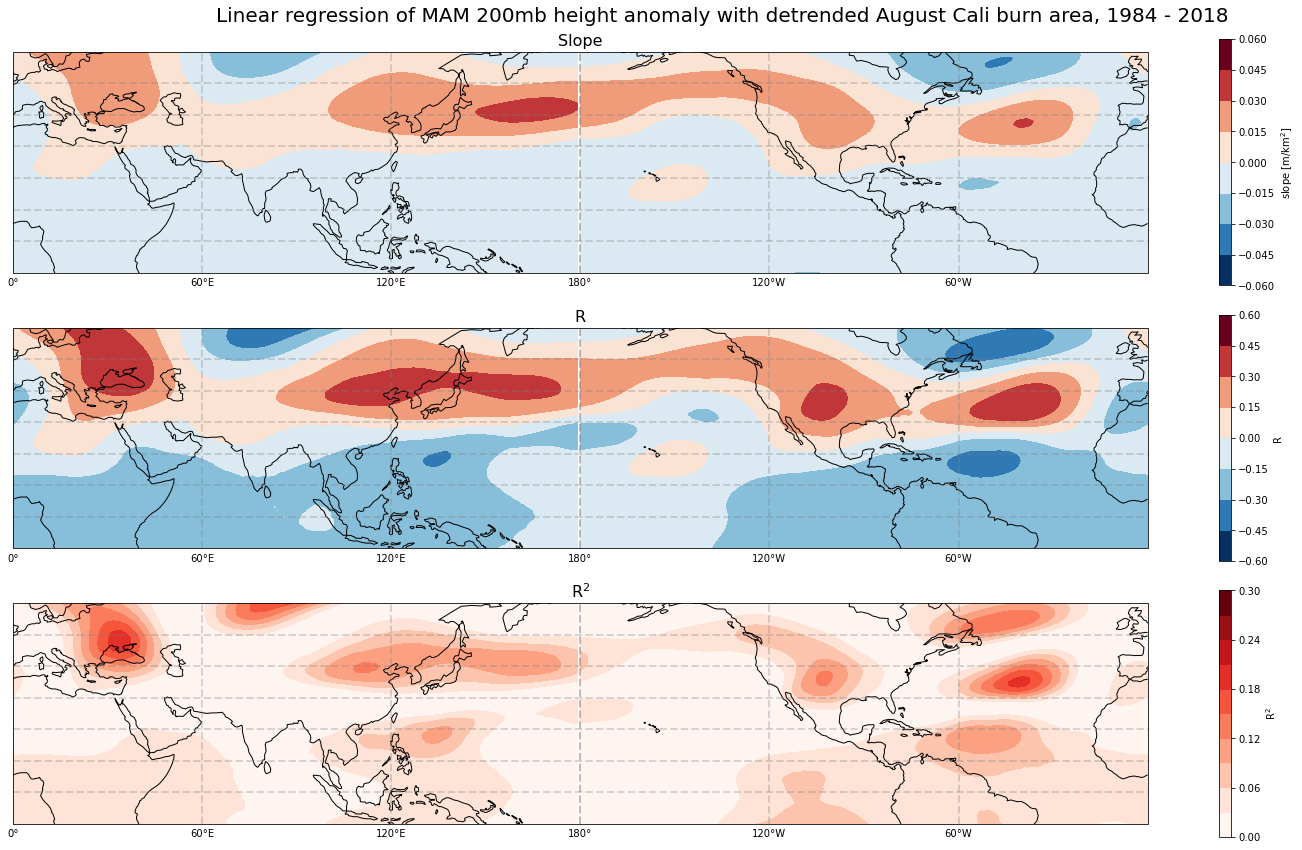

In [226]:
season_idxs = burn_cali.groupby('time.season').groups
z200_fit = z200_anom_m.sel(T=slice('1984-01-15','2018-12-16')).isel(T=season_idxs['MAM']).resample({'T':'AS-MAR'}).mean().groupby('T.year').mean()
z200_burn_fit = xr.merge([z200_fit,ds_m7_detrend])
slopes = xr.apply_ufunc(linear_trend,
                        z200_burn_fit.burnarea, z200_burn_fit.z,
                        vectorize=True,
                        input_core_dims=[['year'], ['year']],# reduce along 'year'
                        )

r = xr.apply_ufunc(rval,
                        z200_burn_fit.burnarea, z200_burn_fit.z,
                        vectorize=True,
                        input_core_dims=[['year'], ['year']],# reduce along 'year'
                        )

plt.subplots(3,1,figsize=(20,12))
extent = [0, 359, -10, 60]

ax = plt.subplot(3,1,1,projection=ccrs.PlateCarree(central_longitude=180))
im = slopes.plot.contourf(ax=ax, levels=9, cmap='RdBu_r',vmax=0.06,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1, 'label':'slope [m/km$^2$]'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent(extent)    
ax.set_title('Slope',fontsize=16)

ax1 = plt.subplot(3,1,3,projection=ccrs.PlateCarree(central_longitude=180))
im = (r**2).plot.contourf(ax=ax1, levels=11, cmap='Reds',vmax = 0.3,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1, 'label':'R$^2$'})
ax1.coastlines()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_extent(extent)    
ax1.set_title('R$^2$',fontsize=16)

ax2 = plt.subplot(3,1,2,projection=ccrs.PlateCarree(central_longitude=180))
im = xr.corr(z200_burn_fit.burnarea, z200_burn_fit.z,dim='year').plot.contourf(ax=ax2, levels=9, cmap='RdBu_r',vmax=0.6,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1,'label':'R'})
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_extent(extent)    
ax2.set_title('R',fontsize=16)

plt.suptitle('Linear regression of MAM 200mb height anomaly with detrended August Cali burn area, 1984 - 2018',fontsize=20)
plt.tight_layout()

In [239]:
season_idxs = z200_anom_m.sel(T=slice('1983-12-15','2018-11-16')).groupby('T.season').groups
z200_fit = z200_anom_m.sel(T=slice('1983-12-15','2018-11-16')).isel(T=season_idxs['DJF']).resample({'T':'AS-DEC'}).mean().groupby('T.year').mean()
z200_fit = z200_fit.assign_coords(year = z200_fit.year + 1).sel(year=slice(1984,2018))
z200_burn_fit = xr.merge([z200_fit,ds_m7_detrend])
slopes = xr.apply_ufunc(linear_trend,
                        z200_burn_fit.burnarea, z200_burn_fit.z,
                        vectorize=True,
                        input_core_dims=[['year'], ['year']],# reduce along 'year'
                        )

r = xr.apply_ufunc(rval,
                        z200_burn_fit.burnarea, z200_burn_fit.z,
                        vectorize=True,
                        input_core_dims=[['year'], ['year']],# reduce along 'year'
                        )

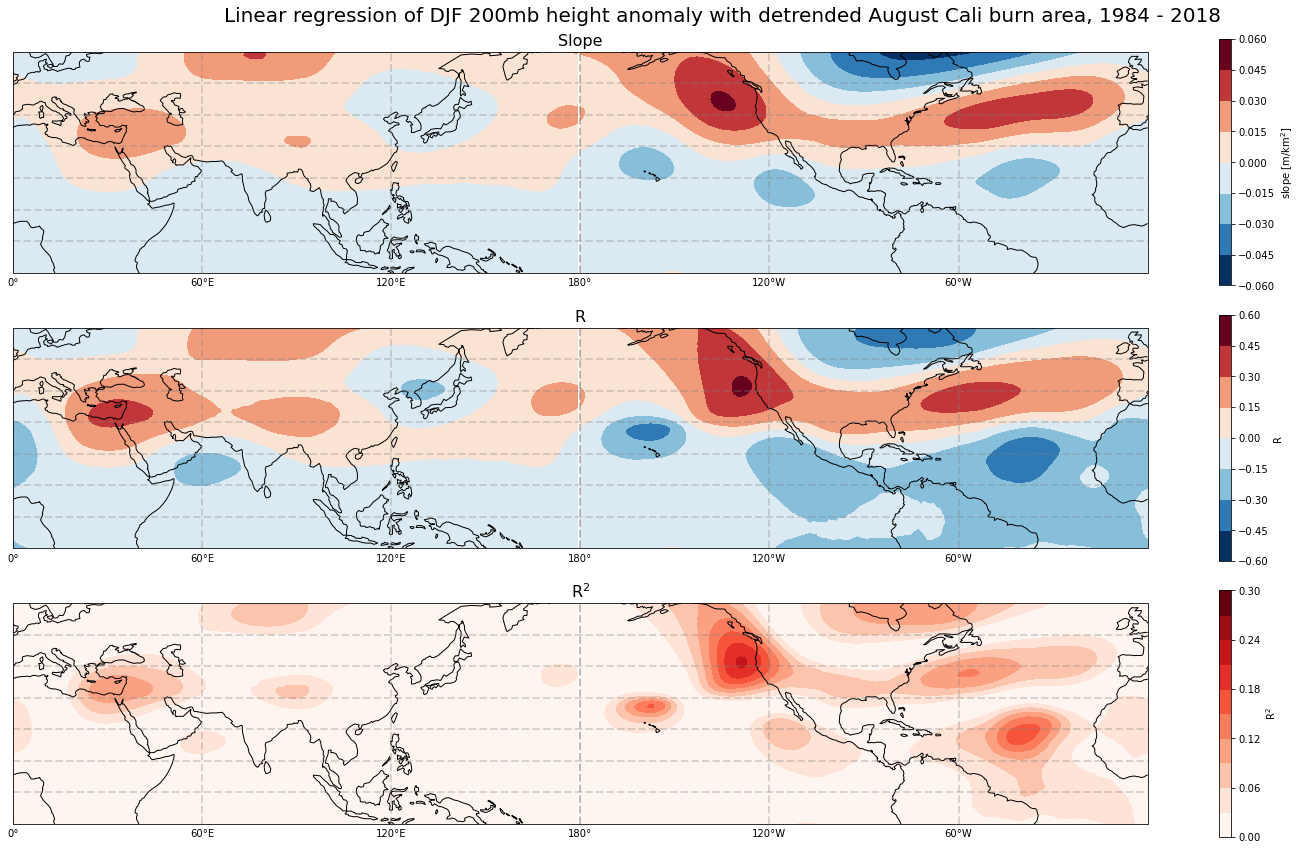

In [241]:
plt.subplots(3,1,figsize=(20,12))
extent = [0, 359, -10, 60]

ax = plt.subplot(3,1,1,projection=ccrs.PlateCarree(central_longitude=180))
im = slopes.plot.contourf(ax=ax, levels=9, cmap='RdBu_r',vmax=0.06,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1, 'label':'slope [m/km$^2$]'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent(extent)    
ax.set_title('Slope',fontsize=16)

ax1 = plt.subplot(3,1,3,projection=ccrs.PlateCarree(central_longitude=180))
im = (r**2).plot.contourf(ax=ax1, levels=11, cmap='Reds',vmax = 0.3,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1, 'label':'R$^2$'})
ax1.coastlines()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_extent(extent)    
ax1.set_title('R$^2$',fontsize=16)

ax2 = plt.subplot(3,1,2,projection=ccrs.PlateCarree(central_longitude=180))
im = xr.corr(z200_burn_fit.burnarea, z200_burn_fit.z,dim='year').plot.contourf(ax=ax2, levels=9, cmap='RdBu_r',vmax=0.6,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1,'label':'R'})
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_extent(extent)    
ax2.set_title('R',fontsize=16)

plt.suptitle('Linear regression of DJF 200mb height anomaly with detrended August Cali burn area, 1984 - 2018',fontsize=20)
plt.tight_layout()

In [274]:
season_idxs = p_anom_m.sel(T=slice('1983-12-15','2018-11-16')).groupby('T.season').groups
precip_fit = p_anom_m.sel(T=slice('1983-12-15','2018-11-16')).isel(T=season_idxs['DJF']).resample({'T':'AS-DEC'}).mean().groupby('T.year').mean()
precip_fit = precip_fit.assign_coords(year = precip_fit.year + 1).sel(year=slice(1984,2018))
precip_burn_fit = xr.merge([precip_fit,ds_m7_detrend])
slopes = xr.apply_ufunc(linear_trend,
                        precip_burn_fit.burnarea, precip_burn_fit.tp,
                        vectorize=True,
                        input_core_dims=[['year'], ['year']],# reduce along 'year'
                        )

r = xr.apply_ufunc(rval,
                        precip_burn_fit.burnarea, precip_burn_fit.tp,
                        vectorize=True,
                        input_core_dims=[['year'], ['year']],# reduce along 'year'
                        )

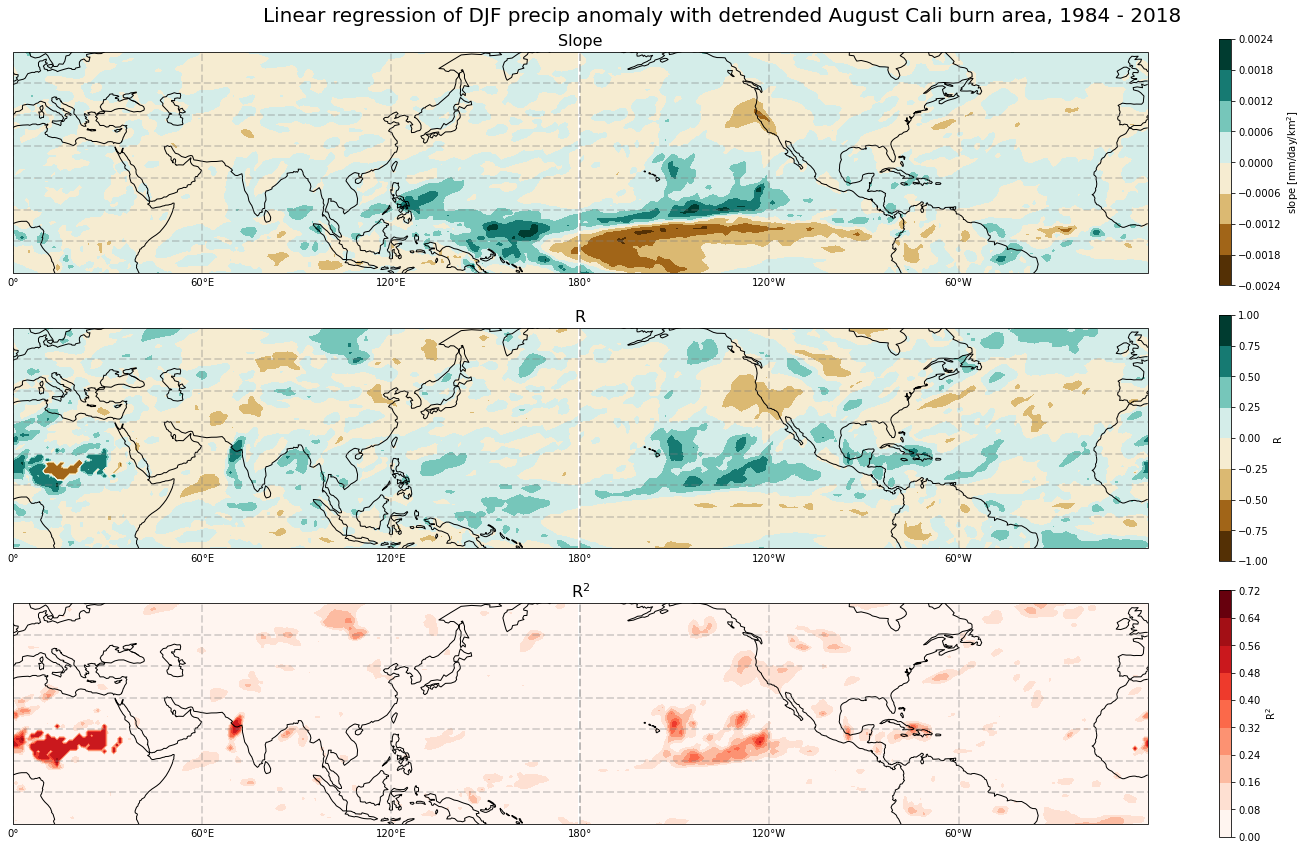

In [279]:
plt.subplots(3,1,figsize=(20,12))
extent = [0, 359, -10, 60]

ax = plt.subplot(3,1,1,projection=ccrs.PlateCarree(central_longitude=180))
im = slopes.plot.contourf(ax=ax, levels=9, cmap='BrBG',transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1, 'label':'slope [mm/day/km$^2$]'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent(extent)    
ax.set_title('Slope',fontsize=16)

ax1 = plt.subplot(3,1,3,projection=ccrs.PlateCarree(central_longitude=180))
im = (r**2).plot.contourf(ax=ax1, levels=11, cmap='Reds',transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1, 'label':'R$^2$'})
ax1.coastlines()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_extent(extent)    
ax1.set_title('R$^2$',fontsize=16)

ax2 = plt.subplot(3,1,2,projection=ccrs.PlateCarree(central_longitude=180))
im = xr.corr(precip_burn_fit.burnarea, precip_burn_fit.tp,dim='year').plot.contourf(ax=ax2, levels=9, cmap='BrBG',transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1,'label':'R'})
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_extent(extent)    
ax2.set_title('R',fontsize=16)

plt.suptitle('Linear regression of DJF precip anomaly with detrended August Cali burn area, 1984 - 2018',fontsize=20)
plt.tight_layout()

## Precip

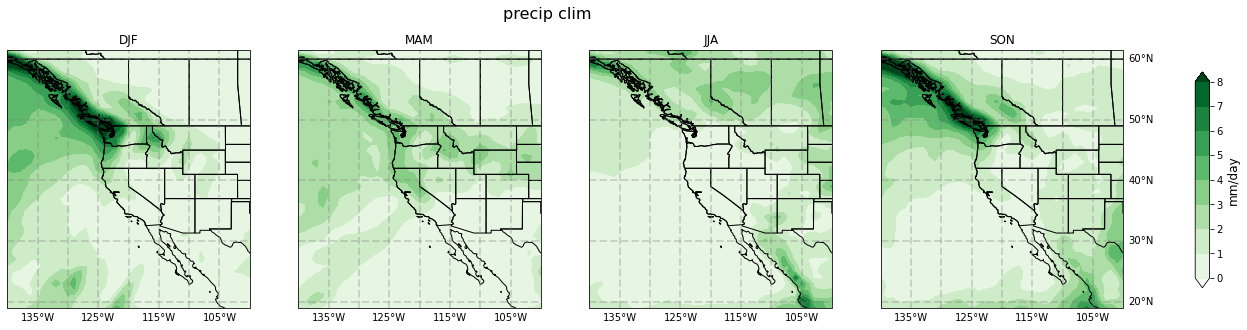

In [11]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
extent = [-140, -100, 19, 60]
seasons=['DJF','MAM','JJA','SON']

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(1,4,i+1,projection=ccrs.PlateCarree())
    im = precip.sel(T=period).groupby('T.season').mean('T').tp.sel(season=seasons[i]).plot.contourf(
        ax=ax, vmin=0, vmax=8, levels=9, cmap='Greens',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    if i<3:
        gl.right_labels=False
    gl.top_labels = False
    gl.left_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.01,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='mm/day',size=12)
plt.suptitle('precip clim',fontsize=16);


Text(0.5, 0.98, 'ERA Interim 2017-2018 precip anomaly')

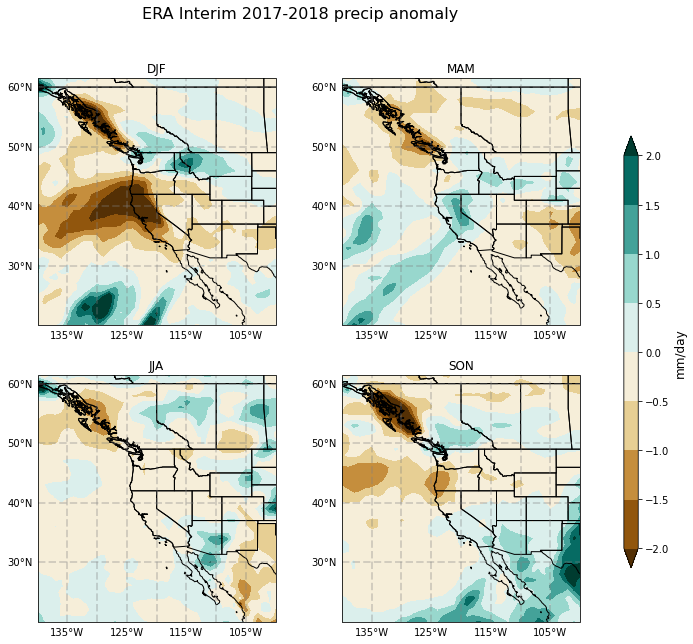

In [589]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])


for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = p_anom_s.sel(T=period).groupby('season').mean().sel(season=seasons[i]).tp.plot.contourf(
        ax=ax, vmin=-2, vmax=2, levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='mm/day',size=12)
plt.suptitle('ERA Interim 2017-2018 precip anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

Text(0.5, 0.98, 'ERA Interim 2016-2017 precip anomaly')

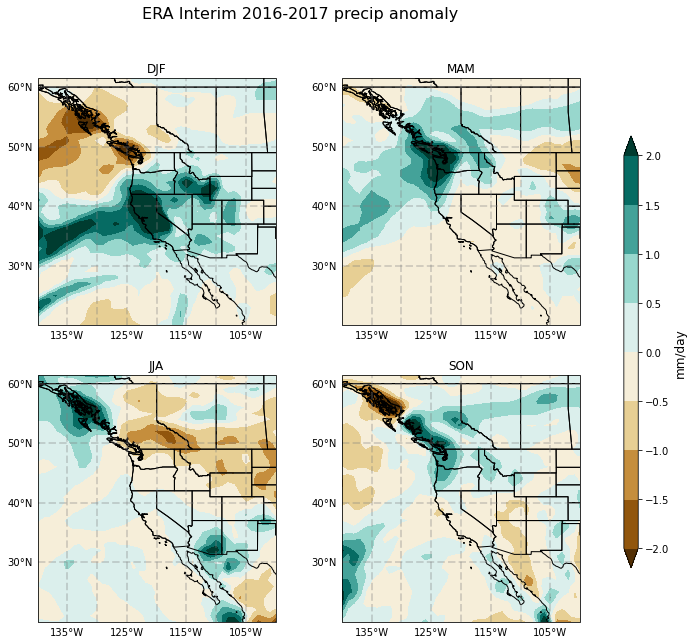

In [590]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])


for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = p_anom_s.sel(T=period1).groupby('season').mean().sel(season=seasons[i]).tp.plot.contourf(
        ax=ax, vmin=-2, vmax=2, levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='mm/day',size=12)
plt.suptitle('ERA Interim 2016-2017 precip anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

## Evap

Text(0.5, 0.98, 'ERA Interim 2017-2018 evap anomaly')

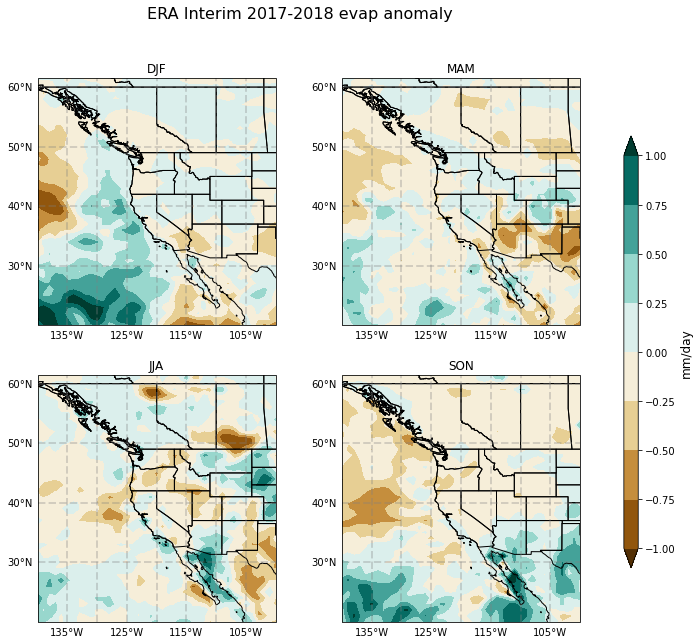

In [591]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = e_anom_s.sel(T=period).groupby('season').mean().sel(season=seasons[i]).evap.plot.contourf(
        ax=ax, vmin=-1, vmax=1, levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='mm/day',size=12)
plt.suptitle('ERA Interim 2017-2018 evap anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

Text(0.5, 0.98, 'ERA Interim 2016-2017 evap anomaly')

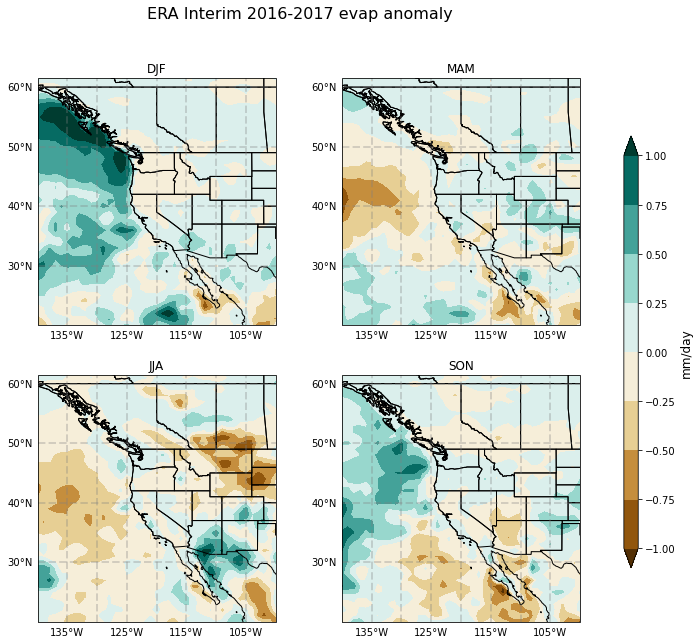

In [592]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = e_anom_s.sel(T=period1).groupby('season').mean().sel(season=seasons[i]).evap.plot.contourf(
        ax=ax, vmin=-1, vmax=1, levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='mm/day',size=12)
plt.suptitle('ERA Interim 2016-2017 evap anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

## Soil moisture

Text(0.5, 0.98, 'ERA Interim 2017-2018 soil moisture level 1 anomaly')

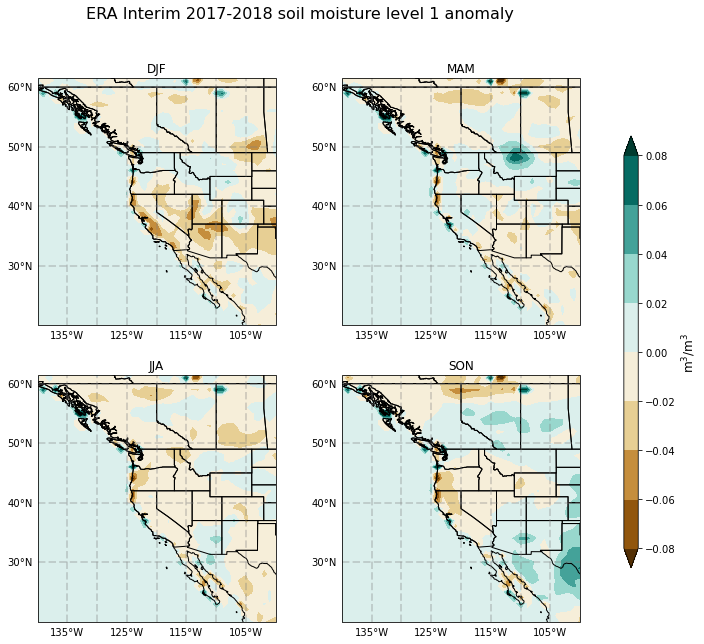

In [593]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = sm_anoms_s[0].sel(T=period).groupby('season').mean().sel(season=seasons[i]).swvl1.plot.contourf(
        ax=ax, vmin=-.08,vmax=0.08,levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='m$^3$/m$^3$',size=12)
plt.suptitle('ERA Interim 2017-2018 soil moisture level 1 anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

In [181]:
soil_depths = [0.07, (7-28)*-0.01, (28-100)*-0.01, (100-289)*-0.01]
oldnames = ['swvl1','swvl2','swvl3','swvl4']
sm_anoms_s_renamed = [sm_anoms_s[i].rename({oldnames[i]:'swv'}) for i in range(len(sm_anoms_s))]
smv_anoms_s = sum([x*y for x,y in zip(sm_anoms_s_renamed,soil_depths)])

Text(0.5, 0.98, 'ERA Interim 2017-2018 soil moisture volume anomaly')

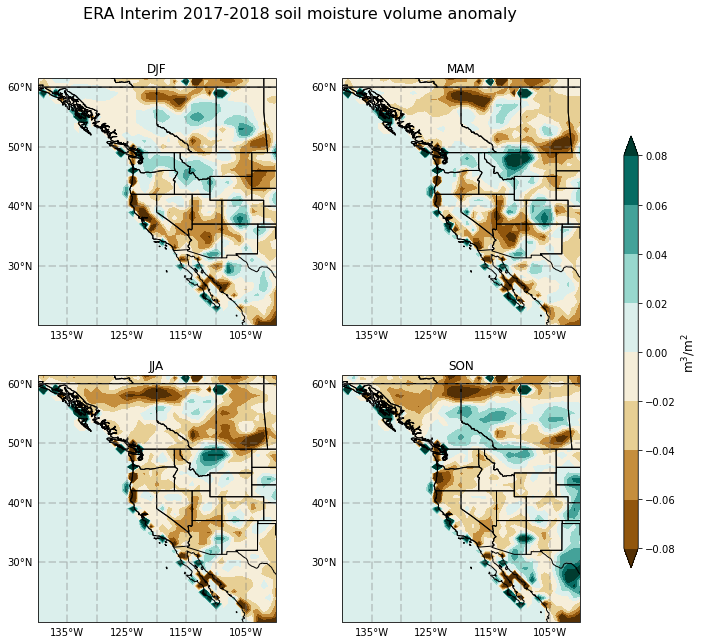

In [594]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = smv_anoms_s.sel(T=period).groupby('season').mean().sel(season=seasons[i]).swv.plot.contourf(
        ax=ax, vmin=-.08,vmax=0.08,levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='m$^3$/m$^2$',size=12)
plt.suptitle('ERA Interim 2017-2018 soil moisture volume anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig


In [197]:
sm_stds_s_renamed = [sm_stds_s[i].rename({oldnames[i]:'swv'}) for i in range(len(sm_stds_s))]
smv_stds_s = sum([x*y for x,y in zip(sm_stds_s_renamed,soil_depths)])

Text(0.5, 0.98, 'ERA Interim 2017-2018 soil moisture volume standardized anomaly')

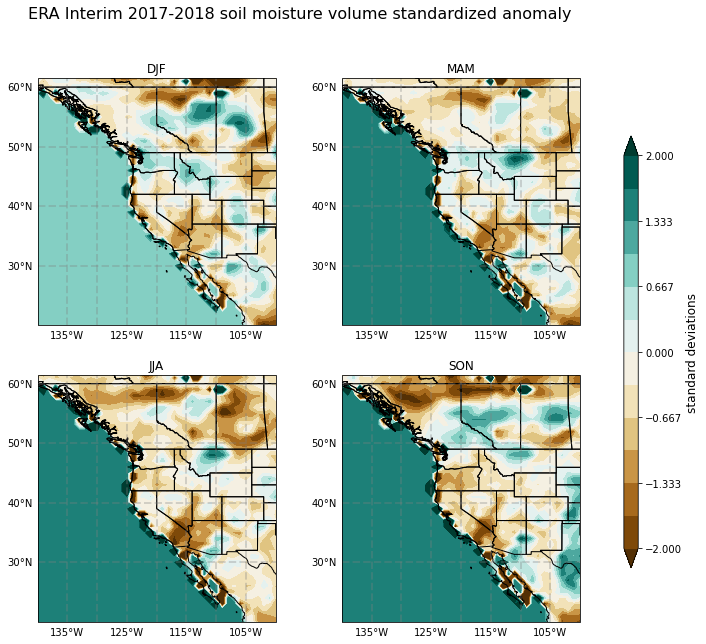

In [595]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = (smv_anoms_s.sel(T=period).groupby('season').mean()/smv_stds_s).sel(season=seasons[i]).swv.plot.contourf(
        ax=ax, vmin=-2,vmax=2,levels=13, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='standard deviations',size=12)
plt.suptitle('ERA Interim 2017-2018 soil moisture volume standardized anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig


Text(0.5, 0.98, 'ERA Interim 2017-2018 soil moisture level 2 anomaly')

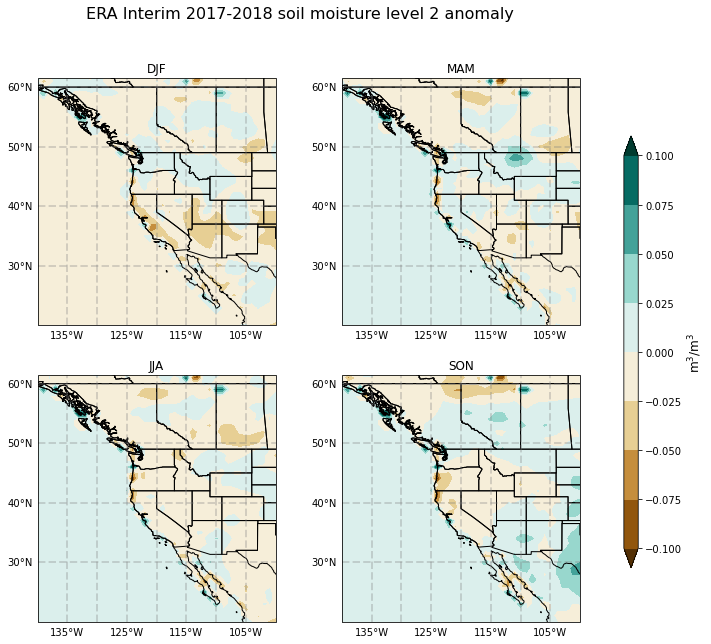

In [596]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = sm_anoms_s[1].sel(T=period).groupby('season').mean().sel(season=seasons[i]).swvl2.plot.contourf(
        ax=ax, vmin=-.1,vmax=0.1,levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='m$^3$/m$^3$',size=12)
plt.suptitle('ERA Interim 2017-2018 soil moisture level 2 anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

Text(0.5, 0.98, 'ERA Interim 2017-2018 soil moisture level 3 anomaly')

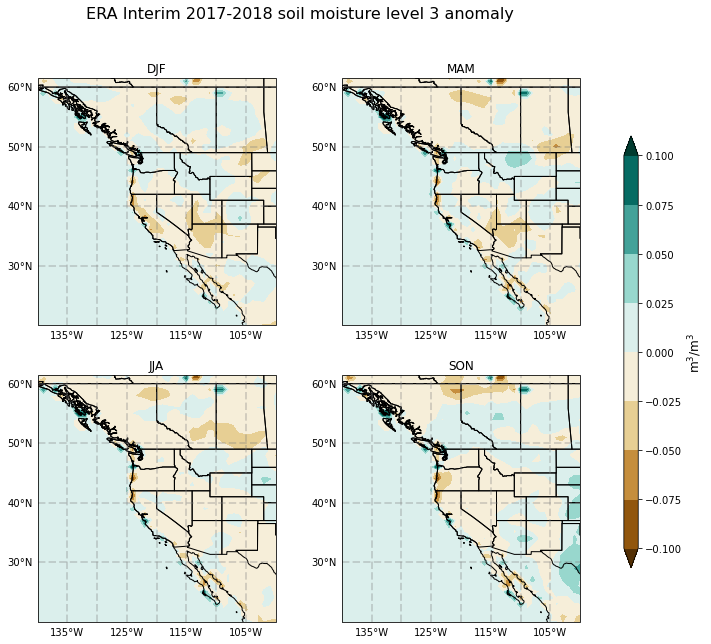

In [597]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = sm_anoms_s[2].sel(T=period).groupby('season').mean().sel(season=seasons[i]).swvl3.plot.contourf(
        ax=ax, vmin=-.1,vmax=0.1,levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='m$^3$/m$^3$',size=12)
plt.suptitle('ERA Interim 2017-2018 soil moisture level 3 anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

Text(0.5, 0.98, 'ERA Interim 2017-2018 soil moisture level 4 anomaly')

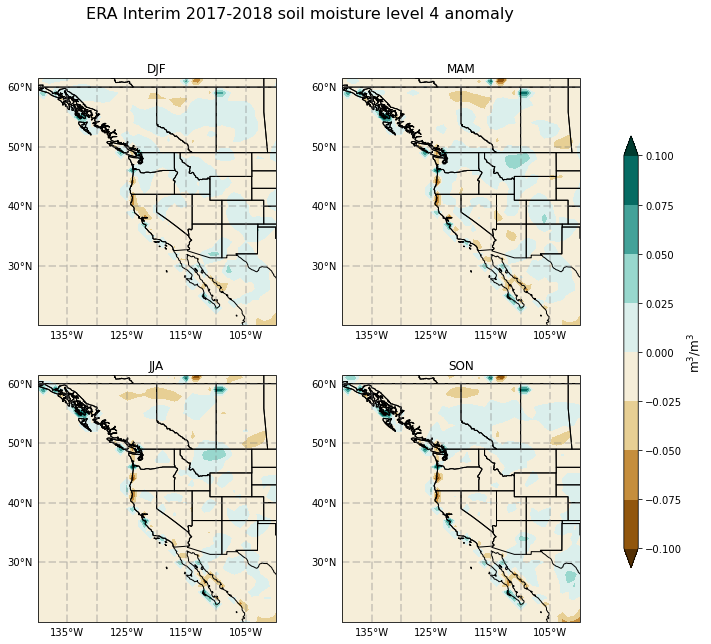

In [598]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = sm_anoms_s[3].sel(T=period).groupby('season').mean().sel(season=seasons[i]).swvl4.plot.contourf(
        ax=ax, vmin=-.1,vmax=0.1,levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='m$^3$/m$^3$',size=12)
plt.suptitle('ERA Interim 2017-2018 soil moisture level 4 anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

## 10m Winds

Text(0.5, 0.98, 'ERA Interim 2017-2018 10m wind anomalies')

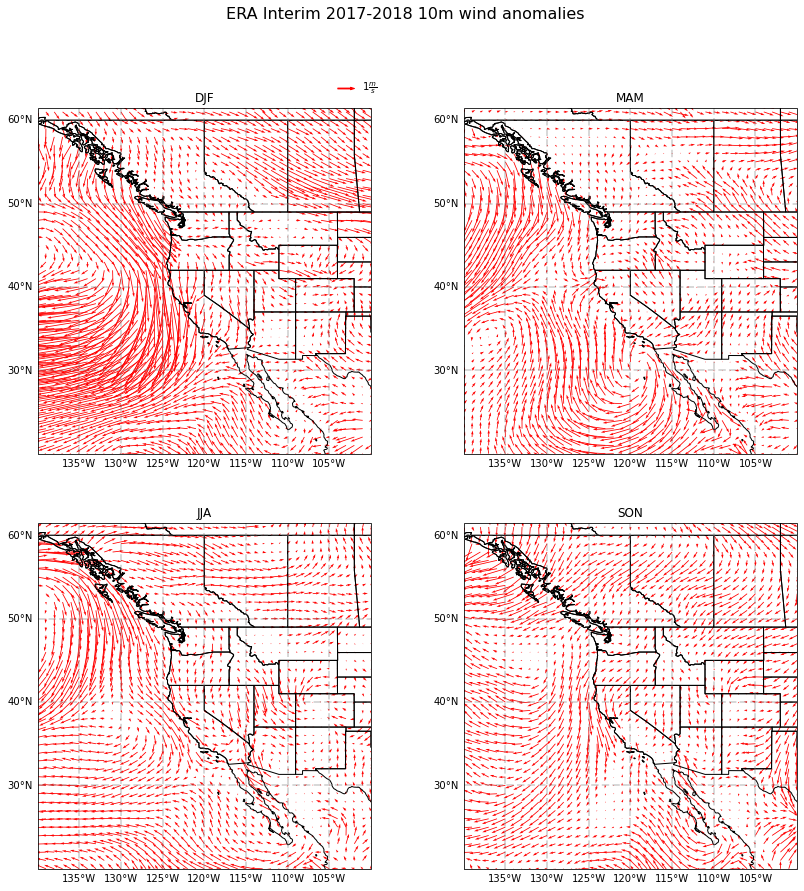

In [599]:
fig, ax = plt.subplots(2,2,figsize=(14,14))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
u_plt = u_anom_s.sel(T=period).groupby('T.season').mean().u10
v_plt = v_anom_s.sel(T=period).groupby('T.season').mean().v10
x = u_plt.lon.values
y = u_plt.lat.values

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    qv = ax.quiver( x, y, u_plt.sel(season=seasons[i]).values, v_plt.sel(season=seasons[i]).values, scale=20,color='r')
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    if i==0:
        ax.quiverkey(qv, 0.45, 0.9 , 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure',color='r',linewidth=1)
    
plt.suptitle('ERA Interim 2017-2018 10m wind anomalies',fontsize=16)


Text(0.5, 0.98, 'ERA Interim 2017-2018 10m winds')

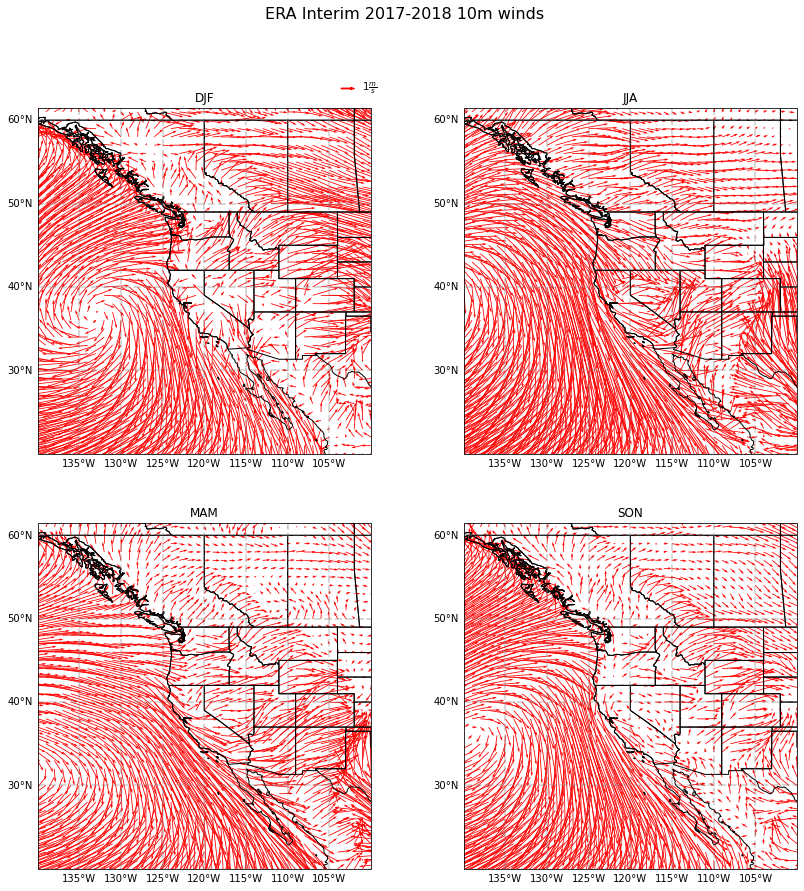

In [140]:
fig, ax = plt.subplots(2,2,figsize=(14,14))
seasons = ['DJF','JJA','MAM','SON']
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
u_plt = u.sel(T=period).groupby('T.season').mean().u10
v_plt = v.sel(T=period).groupby('T.season').mean().v10
x = u_plt.lon.values
y = u_plt.lat.values

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    qv = ax.quiver( x, y, u_plt.sel(season=seasons[i]).values, v_plt.sel(season=seasons[i]).values, scale=25,color='r')
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    if i==0:
        ax.quiverkey(qv, 0.45, 0.9 , 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure',color='r',linewidth=1)
    
plt.suptitle('ERA Interim 2017-2018 10m winds',fontsize=16)


## 700mb winds

Text(0.5, 0.98, 'ERA Interim 2017-2018 700mb wind anomalies')

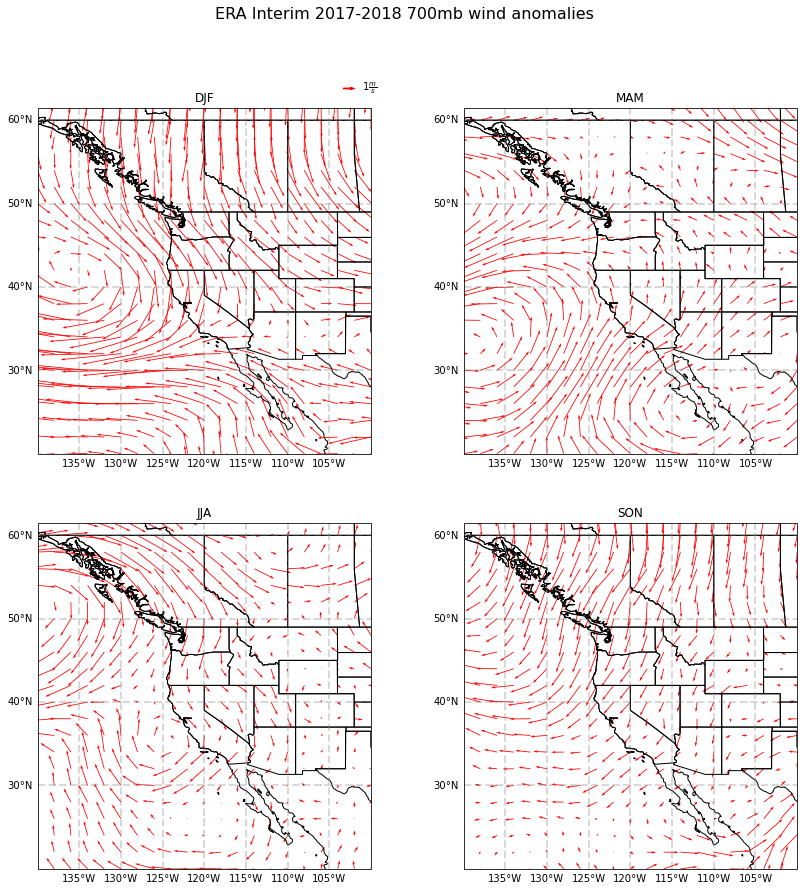

In [381]:
fig, ax = plt.subplots(2,2,figsize=(14,14))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
u_plt = u700_anom_s.sel(T=period).groupby('T.season').mean().u
v_plt = v700_anom_s.sel(T=period).groupby('T.season').mean().v
x = u_plt.lon.values
y = u_plt.lat.values

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    qv = ax.quiver( x[::2], y[::2], u_plt.sel(season=seasons[i]).values[::2,::2], v_plt.sel(season=seasons[i]).values[::2,::2], scale=30,color='r')
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    if i==0:
        ax.quiverkey(qv, 0.45, 0.9 , 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure',color='r',linewidth=1)
    
plt.suptitle('ERA Interim 2017-2018 700mb wind anomalies',fontsize=16)


Text(0.5, 0.98, 'ERA Interim 2017-2018 700mb vertical velocity anomalies')

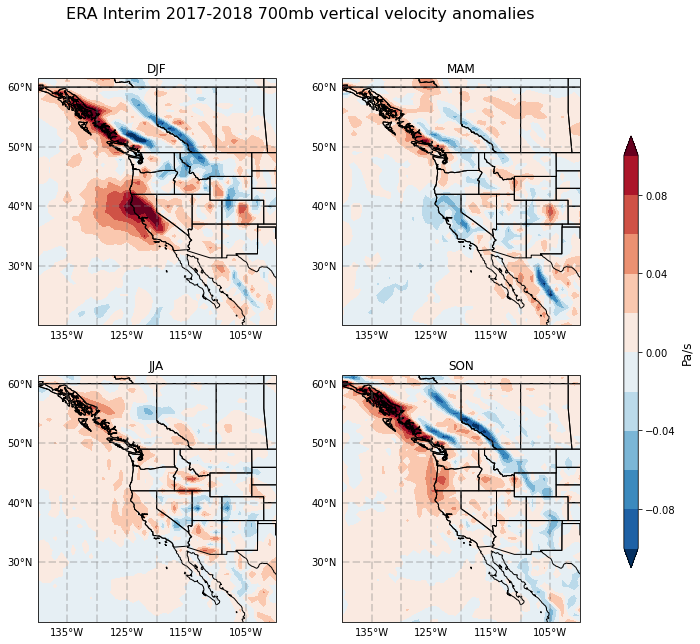

In [382]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = w700_anom_s.sel(T=period).groupby('season').mean().sel(season=seasons[i]).w.plot.contourf(
        ax=ax, vmin=-0.1, vmax = .1, levels=11, cmap='RdBu_r',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='Pa/s',size=12)

plt.suptitle('ERA Interim 2017-2018 700mb vertical velocity anomalies',fontsize=16)


## 2m Temperature

Text(0.5, 0.98, 'ERA Interim 2017-2018 2m Temp anomaly')

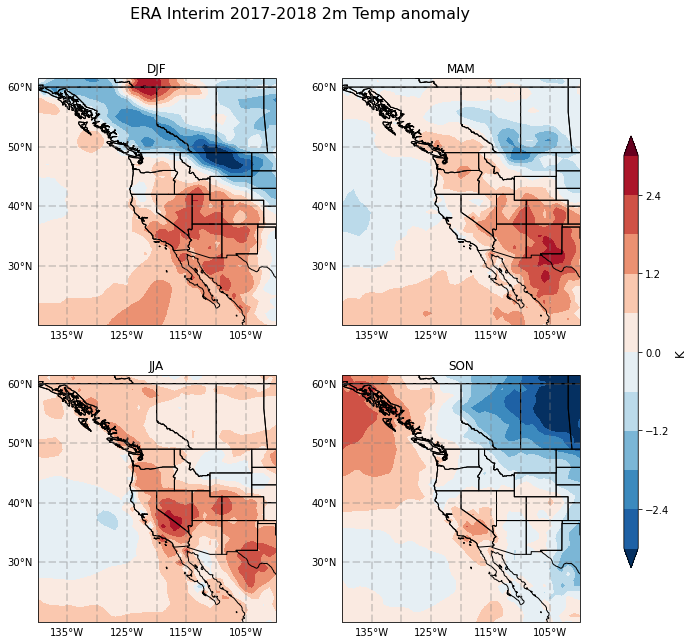

In [384]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])


for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = T_anom_s.sel(T=period).groupby('season').mean().sel(season=seasons[i]).t2m.plot.contourf(
        ax=ax, vmin=-3, vmax=3,levels=11, cmap='RdBu_r',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='K',size=12)
plt.suptitle('ERA Interim 2017-2018 2m Temp anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

Text(0.5, 0.98, 'ERA Interim 2017-2018 2m temp standardized anomaly')

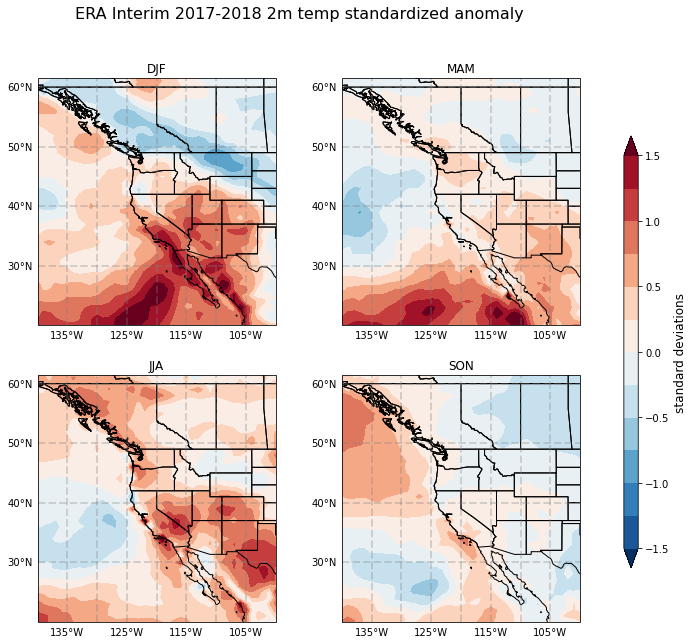

In [600]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])


for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = (T_anom_s.sel(T=period).groupby('season').mean() / T_std_s).sel(season=seasons[i]).t2m.plot.contourf(
        ax=ax, vmin=-1.5, vmax=1.5,levels=13, cmap='RdBu_r',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='standard deviations',size=12)
plt.suptitle('ERA Interim 2017-2018 2m temp standardized anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

## VPD

Text(0.5, 0.98, 'ERA Interim 2017-2018 VPD anomaly')

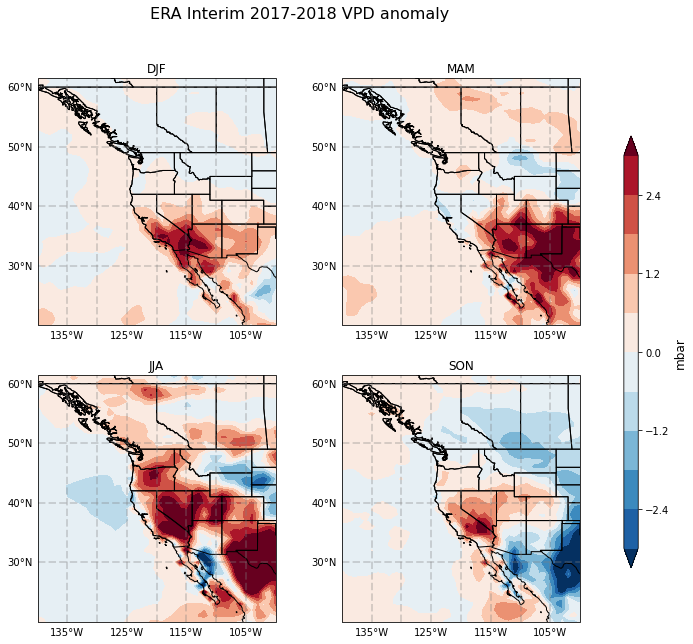

In [387]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])


for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = VPD_anom_s.sel(T=period).groupby('season').mean().sel(season=seasons[i]).VPD.plot.contourf(
        ax=ax, vmin=-3, vmax=3,levels=11, cmap='RdBu_r',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='mbar',size=12)
plt.suptitle('ERA Interim 2017-2018 VPD anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

Text(0.5, 0.98, 'ERA Interim 2017-2018 VPD standardized anomaly')

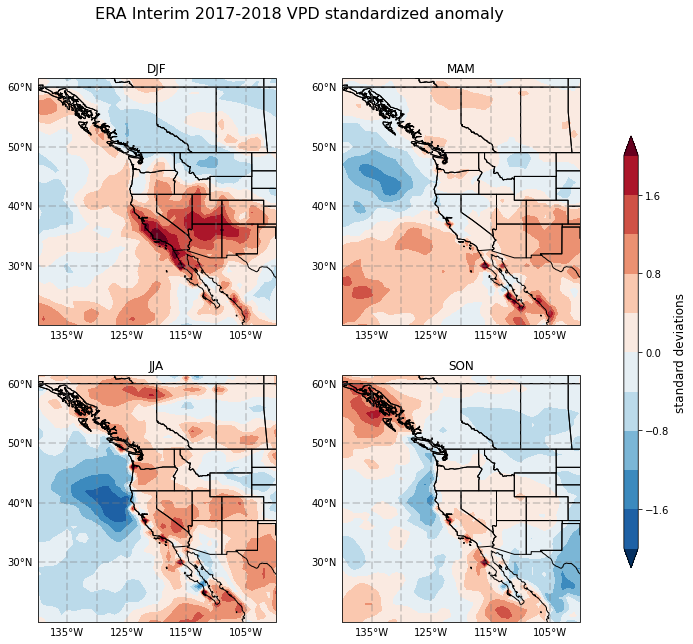

In [601]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
extent = [-140, -100, 20, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])


for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    im = (VPD_anom_s.sel(T=period).groupby('season').mean()/VPD_std_s).sel(season=seasons[i]).VPD.plot.contourf(
        ax=ax, vmin=-2, vmax=2,levels=11, cmap='RdBu_r',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='standard deviations',size=12)
plt.suptitle('ERA Interim 2017-2018 VPD standardized anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

# global 
## SST

Text(0.5, 0.98, 'ERA Interim 2017-2018 sst anomaly')

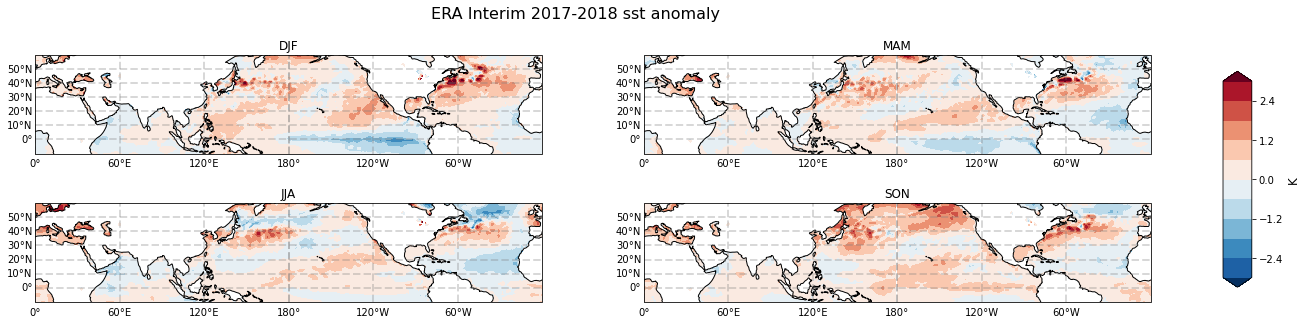

In [357]:
fig, ax = plt.subplots(2,2,figsize=(20,5))
extent = [0, 359, -10, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])


for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    im = sst_anom_s.sel(T=period).groupby('season').mean().sel(season=seasons[i]).sst.plot.contourf(
        ax=ax, vmin=-3, vmax=3,levels=11, cmap='RdBu_r',add_colorbar=False,transform=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='K',size=12)
plt.suptitle('ERA Interim 2017-2018 sst anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

## winds

/usr/local/python/anaconda3/envs/pangeo-Fall2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)


Text(0.5, 0.98, 'ERA Interim 2017-2018 700mb wind anomalies')

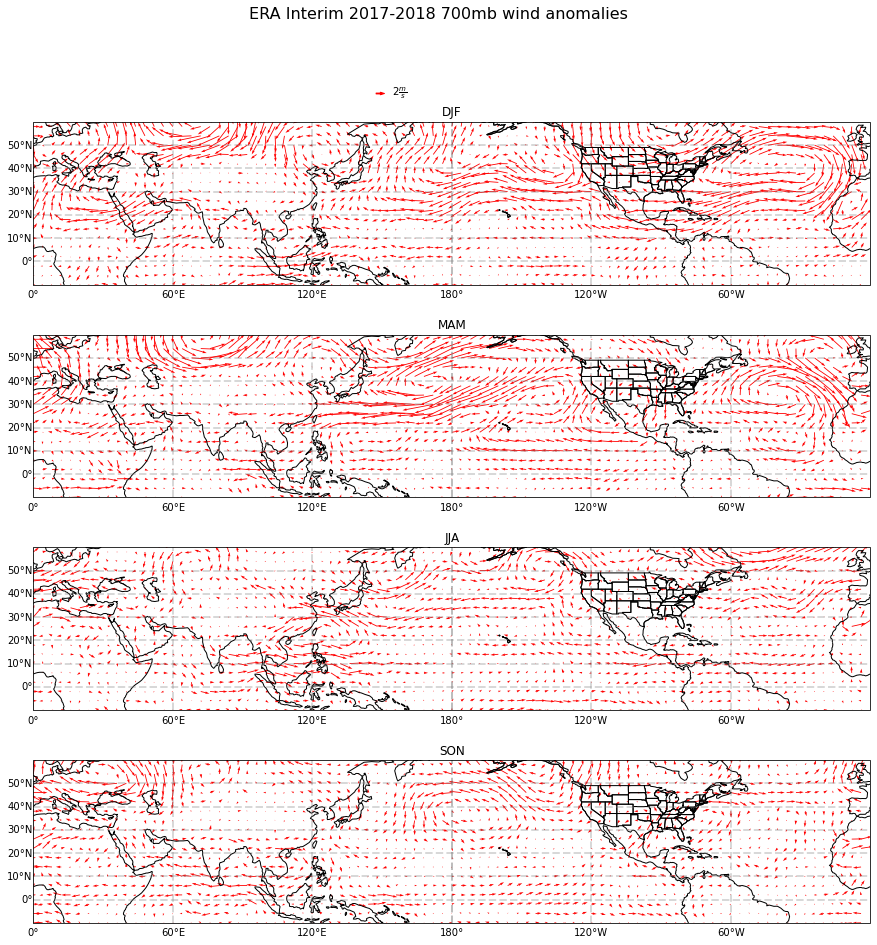

In [28]:
fig, ax = plt.subplots(2,2,figsize=(15,15))
extent = [0, 359, -10, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
u_plt = (u700_anom_s.sel(T=period).groupby('T.season').mean().u)
v_plt = (v700_anom_s.sel(T=period).groupby('T.season').mean().v)
x = u_plt.lon.values
y = u_plt.lat.values

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(4,1,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    qv = ax.quiver( x[::4], y[::4], u_plt.sel(season=seasons[i]).values[::4,::4], v_plt.sel(season=seasons[i]).values[::4,::4],width=1e-3, scale = 200, color='r',
                  transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    if i==0:
        ax.quiverkey(qv, 0.45, 0.9 , 2, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure',color='r',linewidth=1)
    
plt.suptitle('ERA Interim 2017-2018 700mb wind anomalies',fontsize=16)


Text(0.5, 0.98, 'ERA Interim 2017-2018 700mb vertical velocity anomalies')

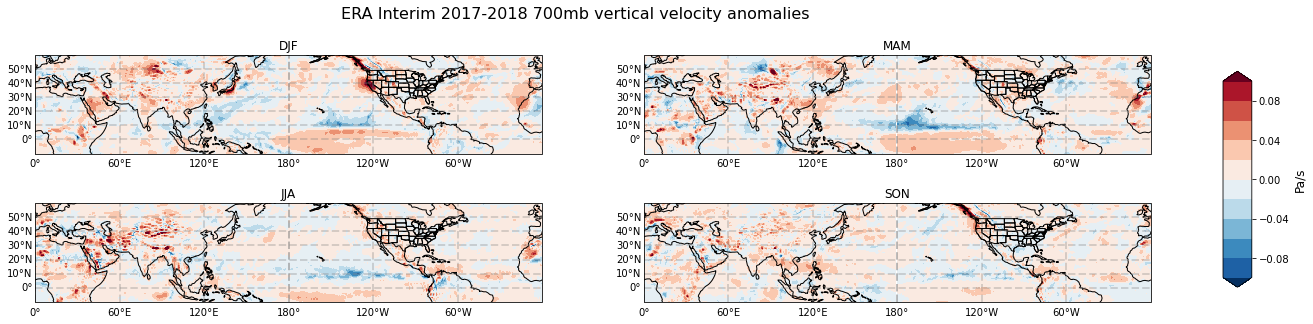

In [377]:
fig, ax = plt.subplots(2,2,figsize=(20,5))
extent = [0, 359, -10, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    im = w700_anom_s.sel(T=period).groupby('season').mean().sel(season=seasons[i]).w.plot.contourf(
        ax=ax, vmin=-0.1, vmax = .1, levels=11, cmap='RdBu_r',add_colorbar=False, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='Pa/s',size=12)

plt.suptitle('ERA Interim 2017-2018 700mb vertical velocity anomalies',fontsize=16)


## 200mb height 

Text(0.5, 0.98, 'ERA Interim 2017-2018 200 mbar height anomaly')

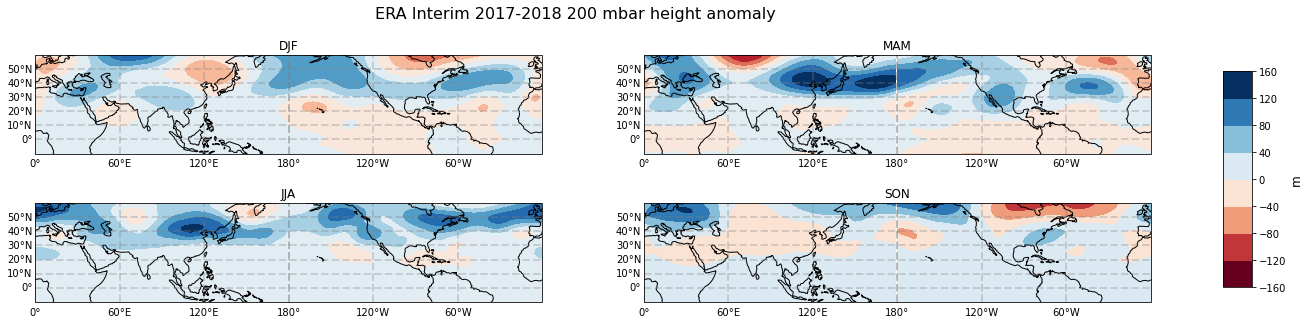

In [13]:
fig, ax = plt.subplots(2,2,figsize=(20,5))
extent = [0, 359, -10, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])


for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    im = z200_anom_s.sel(T=period).groupby('season').mean().sel(season=seasons[i]).z.plot.contourf(
        ax=ax, levels=11, cmap='RdBu',add_colorbar=False,transform=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='m',size=12)
plt.suptitle('ERA Interim 2017-2018 200 mbar height anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

## precip

Text(0.5, 0.98, 'ERA Interim 2017-2018 precip anomaly')

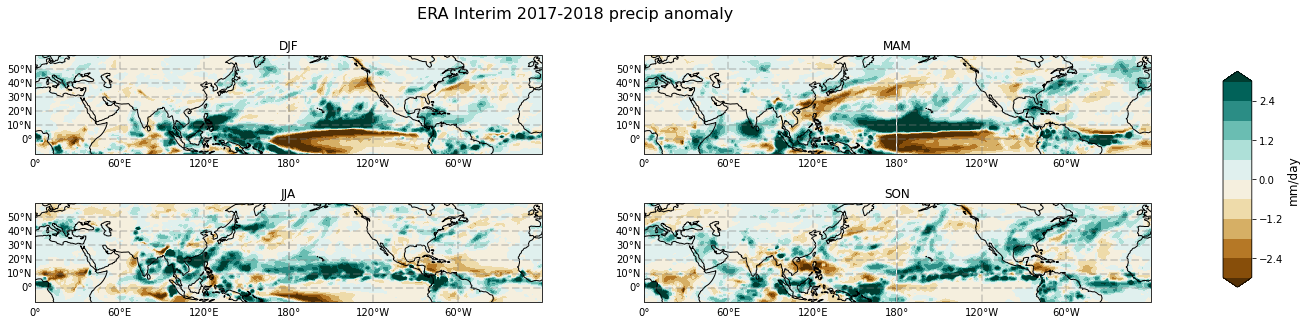

In [372]:
fig, ax = plt.subplots(2,2,figsize=(20,5))
extent = [0, 359, -10, 60]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])


for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    im = p_anom_s.sel(T=period).groupby('season').mean().sel(season=seasons[i]).tp.plot.contourf(
        ax=ax, vmin=-3, vmax=3,levels=11, cmap='BrBG',add_colorbar=False,transform=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='mm/day',size=12)
plt.suptitle('ERA Interim 2017-2018 precip anomaly',fontsize=16)
#plt.tight_layout()
#plt.savefig

qs: 

what dataset to use for burned area? MODIS?
is u10/v10 ok for winds? should i look at wind anomaly or actual wind conditions?
VPD calculation? 
how to use w to look at subsidance? 

should i divide by std for precip?

In [354]:
u_plt.sel(season=seasons[i]).values[::2,::2].shape

(91, 180)

In [353]:
v_plt.sel(season=seasons[i]).values[::2,::2].shape


(91, 180)